In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy
import os
import json
from tqdm.auto import tqdm
import copy
from scipy.interpolate import splrep, BSpline, make_lsq_spline
from matplotlib.patches import Rectangle
from project import adjustmaps
import pickle as pickle
import itertools
from itertools import product
from model import Model
import time
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.animation as animation
from scipy.optimize import minimize
import h5py

project = sg.get_project()
# schema = project.detect_schema(); schema

[Patricks-Mini.search.charter.net:40914] shmem: mmap: an error occurred while determining whether or not /var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T//ompi.Patricks-Mini.501/jf.0/3150184448/sm_segment.Patricks-Mini.501.bbc40000.0 could be created.


## Interpolating $P(<\text{metric}>|\tau)$

In [2]:
metric = "P_s"
Aeff = 1.0
t_final = 600
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
with open(fn_prefix + 'metric_data.pkl', 'rb') as handle:
    metric_data = pickle.load(handle)
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
tau_vec = b_vec * gamma(1+1/c)
all_tau = np.load('data/Aeff_1.0/tfinal_600/all_tau.npy')
all_metric = metric_data['all_metric']

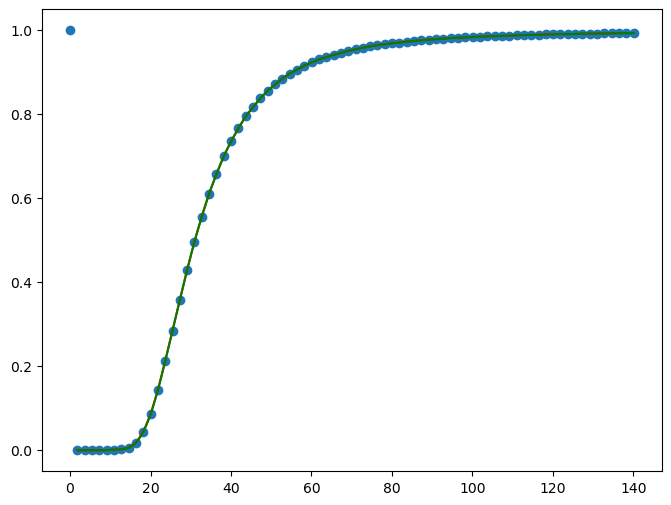

In [3]:
fig, ax = plt.subplots(1, figsize=(8,6))
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
plt.scatter(tau_vec, metric_expect_vec)
# Make best fit Bspline
'''Also works, so I can reduce b samples by a factor of 4 (at least, for this metric and this species, might need more if curve was more complex)'''
'''Can get away with even sparser sampling if k increased'''
t = tau_vec[2:-2:1] 
k = 3
# t = np.r_[(tau_vec[1],)*(k+1),
#           t,
#           (tau_vec[-1],)*(k+1)]
t = np.r_[(0,)*(k+1),
          t,
          (tau_vec[-1],)*(k+1)]
# t = tau_vec[1:]
# k = 3
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)
plt.plot(tau_vec[1:], spl(tau_vec[1:]), c='r')
xnew = np.linspace(tau_vec[1], tau_vec[-1], 200)
plt.plot(xnew, spl(xnew), c='g')
# interp = scipy.interpolate.interp1d(tau_vec[1:], metric_expect_vec, kind='cubic')
# plt.plot(tau_vec, interp(tau_vec), c='r')

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_7816/3650609350.py:14: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)


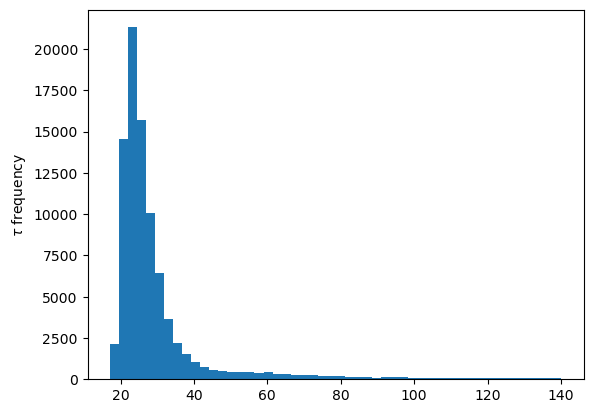

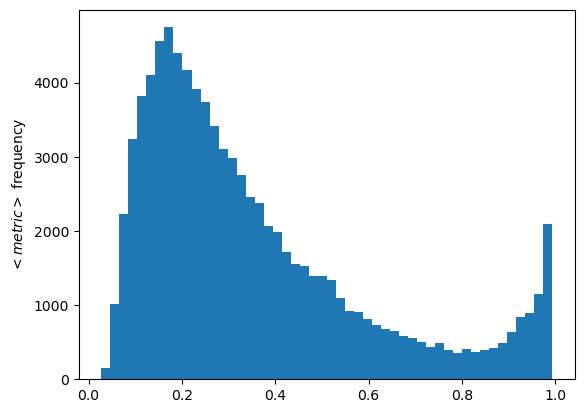

In [4]:
# Get histogram of <metric> over all cells based on above spl
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt]
plt.hist(tau_flat[tau_flat <= max(tau_vec)], bins=50); 
plt.ylabel(r"$\tau$ frequency")
plt.show()
plt.hist(spl(tau_flat[tau_flat <= max(tau_vec)]), bins=50);
plt.ylabel(r"$<metric>$ frequency")
plt.show()

## Uncertainty correlations

In [2]:
metric = "P_s"
metric_lab = '$<P_s>$'
Aeff = 1.0
t_final = 600
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
A_cell = 270**2 / 1e6 #km^2
ncell_tot = 87_993
C_vec = np.load(fn_prefix + "C_vec.npy")
# tauc_range_avg = C_vec / ncell_tot
ncell_vec = np.load(fn_prefix + "ncell_vec.npy")
alteration_areas = ncell_vec * A_cell
slice_left_all = np.load(fn_prefix + "slice_left_all.npy")
tauc_methods = ["flat"]
eps_axes = {}
with h5py.File(fn_prefix + "/eps_axes.h5", "r") as handle:
    for key in handle.keys():
        eps_axes.update({key: handle[key][()]})
        
# Collect <metric> across all state variables and uncertainty parameterizations
shape = [len(eps_axes[key]) for key in eps_axes.keys()] 
shape += [len(C_vec), len(ncell_vec), len(slice_left_all)]
phase_full = np.ones((shape)) * np.nan
with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    for eps_params in itertools.product(*eps_axes.values()):
        # Create a dictionary of indices along with values for the current combination
        eps_params_dict = {
            key: (index, np.round(value, 3)) for key, values in zip(eps_axes.keys(), eps_axes.values())
            for index, value in enumerate(values) if value == eps_params[list(eps_axes.keys()).index(key)]
        }
        
        # Get phase slice at this epsilon parameterization
        data_key = f"{eps_params_dict['mu_tau'][1]}/{eps_params_dict['sigm_tau'][1]}/"
        data_key += f"{eps_params_dict['mu_tauc'][1]}/{eps_params_dict['sigm_tauc'][1]}/phase"
        phase_slice = phase_handle[data_key][:]
        
        # Add them to collective phase_all
        eps_indices = [val[0] for val in eps_params_dict.values()]
        index_tuple = tuple(eps_indices) + (slice(None), slice(None), slice(None))
        phase_full[index_tuple] = phase_slice

In [3]:
rob_thresh_vec = np.linspace(min(phase_full.flatten()), max(phase_full.flatten()), 100)
maxrob = np.ones((len(rob_thresh_vec), len(C_vec))) * np.nan
argmaxrob = np.ones((len(rob_thresh_vec), len(C_vec), 2)) * np.nan
tot_eps_samples = np.cumprod([len(axis) for axis in eps_axes.values()])[-1]
zero_eps_i = [np.argwhere(ax == 0)[0][0] for ax in eps_axes.values()]
for (thresh_i, thresh), (C_i, C) in product(enumerate(rob_thresh_vec), 
                                            enumerate(C_vec)):
    rob_slice = np.ones((len(ncell_vec), len(slice_left_all))) * np.nan
    for (ncell_i, ncell), (sl_i, sl) in product(enumerate(ncell_vec),
                                                enumerate(slice_left_all)):
        # First, check that this result is feasible with zero uncertainty
        # Skip and keep at nan if not feasible
        metric_zero_eps = phase_full[tuple(zero_eps_i + [C_i, ncell_i, sl_i])]
        if np.isnan(metric_zero_eps) or (metric_zero_eps < thresh): continue
        # Now, get the robstness at this (C,ncell,slice_left) coordinate and store
        counts = np.count_nonzero(phase_full[..., C_i, ncell_i, sl_i] >= thresh)
        robustness = counts / tot_eps_samples
        rob_slice[ncell_i, sl_i] = robustness
    if np.any(~np.isnan(rob_slice)):
        # Store the max robustness at this (thresh, C) coordinate
        maxrob[thresh_i, C_i] = np.nanmax(rob_slice)
        # Also store the optimal param indices
        optimal_param_i = np.unravel_index(np.nanargmax(rob_slice, axis=None), rob_slice.shape)
        argmaxrob[thresh_i, C_i] = optimal_param_i

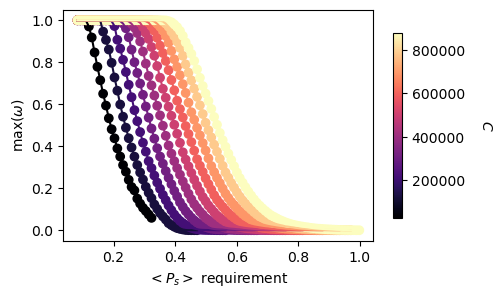

In [4]:
fig, ax = plt.subplots(1, figsize=(5,3))
ax_fontsize = 10
colormap = copy.copy(matplotlib.cm.magma)
vmax = max(C_vec); vmin = min(C_vec)
normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
colors = colormap(normalize(C_vec))
for C_i, C in enumerate(C_vec):
    plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        # Get the maximum robustness across (ncell, sl) at this C 
        plot_vec[thresh_i] = maxrob[thresh_i, C_i]
    ax.plot(rob_thresh_vec, plot_vec, color=colors[C_i])
    scatter = ax.scatter(rob_thresh_vec, plot_vec, 
                         cmap=colormap, norm=normalize,
                        c=np.repeat(C, len(rob_thresh_vec)))
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(fr"$C$", rotation=-90, fontsize=ax_fontsize, labelpad=20)
ax.set_ylabel(fr"$\text{{max}}(\omega)$")
ax.set_xlabel(fr"{metric_lab} requirement")
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/maxrob.png"
fig.savefig(fn, bbox_inches='tight')

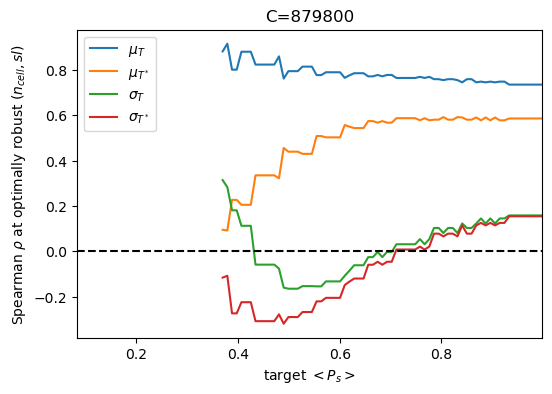

In [5]:
fig, ax = plt.subplots(1, figsize=(6,4))
C_i = 9
num_eps = len(eps_axes.items())
eps_labels = ["$\mu_T$", "$\mu_{T^*}$", "$\sigma_T$", "$\sigma_{T^*}$"]
for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
    plot_vec = np.ones(rob_thresh_vec.size) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        # Check for feasibility at this threshold
        if np.all(np.isnan(argmaxrob[thresh_i, C_i])): continue
        '''Also skip if max(omega)=1 bc dunno how to deal with these yet w/o more eps sampling'''
        if maxrob[thresh_i, C_i] == 1: continue
        opt_ncell_i, opt_sl_i = [int(i) for i in argmaxrob[thresh_i, C_i]]
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, opt_ncell_i, opt_sl_i)
            phase_slice = phase_full[full_slice]
            all_y.append(phase_slice.flatten().tolist())
            all_x.append(np.repeat(eps_val, phase_slice.size).tolist())
        spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
        plot_vec[thresh_i] = spear.statistic
    ax.plot(rob_thresh_vec, plot_vec, label=eps_labels[eps_ax_i])
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlim(rob_thresh_vec.min(), rob_thresh_vec.max())
ax.set_xlabel(rf"target {metric_lab}")
ax.set_ylabel(rf"Spearman $\rho$ at optimally robust $(n_{{cell}}, sl)$")
ax.set_title(f"C={C_vec[C_i]}")
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/epscorr.png"
fig.savefig(fn, bbox_inches='tight')

In [6]:
def metric_corr_at_optimum(thresh_i, C_i):
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs_flat = axs.flatten()

    num_eps = len(eps_axes.items())
    eps_labels = ["$\mu_T$", "$\mu_{T^*}$", "$\sigma_T$", "$\sigma_{T^*}$"]
    if np.all(~np.isnan(argmaxrob[thresh_i, C_i])):
        opt_ncell_i, opt_sl_i = [int(i) for i in argmaxrob[thresh_i, C_i]]
        for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
            all_x = []
            all_y = []
            for eps_val_i, eps_val in enumerate(eps_ax):
                eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
                full_slice = eps_slice + (C_i, opt_ncell_i, opt_sl_i)
                phase_slice = phase_full[full_slice]
                all_y.append(phase_slice.flatten().tolist())
                all_x.append(np.repeat(eps_val, phase_slice.size).tolist())
            spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
            axs_flat[eps_ax_i].violinplot(all_y, positions=np.unique(all_x))
            axs_flat[eps_ax_i].plot([], [], label=rf"$\rho={np.round(spear.statistic,2)}, p={np.round(spear.pvalue,2)}$")
            axs_flat[eps_ax_i].axhline(rob_thresh_vec[thresh_i], ls='--', c='k')
            axs_flat[eps_ax_i].set_xlabel(rf"{eps_labels[eps_ax_i]}")
            # axs_flat[eps_ax_i].set_ylabel(rf"{metric_lab} at optimal $(A,T^*,\vec{{T}}_i)$ given {eps_labels[eps_ax_i]}")
            axs_flat[eps_ax_i].set_ylabel(rf"{metric_lab} at optimally robust strategy")
            axs_flat[eps_ax_i].legend()
    
    title = rf"{metric_lab}$\geq{np.round(rob_thresh_vec[thresh_i], 2)}$,  $max(\omega)={np.round(maxrob[thresh_i,C_i], 3)}$"
    if np.all(~np.isnan(argmaxrob[thresh_i, C_i])):
         title += rf" at $(n_{{cell}}, sl)={(ncell_vec[opt_ncell_i], slice_left_all[opt_sl_i])}$"
    fig.suptitle(title, fontsize=16)

interact(metric_corr_at_optimum,
         thresh_i = widgets.IntSlider(min=0, max=len(rob_thresh_vec)-1, step=1, value=50),
         C_i = widgets.IntSlider(min=0, max=9, step=1, value=5))

interactive(children=(IntSlider(value=50, description='thresh_i', max=99), IntSlider(value=5, description='C_i…

<function __main__.metric_corr_at_optimum(thresh_i, C_i)>

In [ ]:
def metric_corr(thresh_i, C_i, ncell_i, sl_i):
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs_flat = axs.flatten()

    num_eps = len(eps_axes.items())
    eps_labels = ["$\mu_T$", "$\mu_{T^*}$", "$\sigma_T$", "$\sigma_{T^*}$"]
    for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, ncell_i, sl_i)
            phase_slice = phase_full[full_slice]
            all_y.append(phase_slice.flatten().tolist())
            all_x.append(eps_val)
        axs_flat[eps_ax_i].violinplot(all_y, positions=all_x)
        axs_flat[eps_ax_i].axhline(rob_thresh_vec[thresh_i], ls='--', c='k')
        axs_flat[eps_ax_i].set_xlabel(rf"{eps_labels[eps_ax_i]}")
        axs_flat[eps_ax_i].set_ylabel(rf"{metric_lab} at optimally robust strategy")
    
    title = rf"{metric_lab}$\geq{np.round(rob_thresh_vec[thresh_i], 2)}$,  $max(\omega)={maxrob[thresh_i,C_i]}$"
    title += rf" at $(n_{{cell}}, sl)={(ncell_vec[ncell_i], slice_left_all[sl_i])}$"
    fig.suptitle(title, fontsize=16)

interact(metric_corr,
         thresh_i = widgets.IntSlider(min=0, max=len(rob_thresh_vec)-1, step=1, value=0),
         C_i = widgets.IntSlider(min=0, max=len(C_vec)-1, step=1, value=0),
         ncell_i = widgets.IntSlider(min=0, max=len(ncell_vec)-1, step=1, value=0),
         sl_i = widgets.IntSlider(min=0, max=len(slice_left_all)-1, step=1, value=0))

## Multiple uncertainty axes

In [7]:
metric = "P_s"
metric_lab = '$<P_s>$'
Aeff = 1.0
t_final = 600
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
A_cell = 270**2 / 1e6 #km^2
ncell_tot = 87_993
C_vec = np.load(fn_prefix + "C_vec.npy")
# tauc_range_avg = C_vec / ncell_tot
ncell_vec = np.load(fn_prefix + "ncell_vec.npy")
alteration_areas = ncell_vec * A_cell
slice_left_all = np.load(fn_prefix + "slice_left_all.npy")
tauc_methods = ["flat"]
eps_axes = {}
with h5py.File(fn_prefix + "/eps_axes.h5", "r") as handle:
    for key in handle.keys():
        eps_axes.update({key: handle[key][()]})

In [8]:
# shape = [len(tauc_methods
shape = [len(eps_axes[key]) for key in eps_axes.keys()] 
shape += [len(C_vec), len(ncell_vec), len(slice_left_all)]
phase_full = np.ones((shape)) * np.nan
with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    for eps_params in itertools.product(*eps_axes.values()):
        # Create a dictionary of indices along with values for the current combination
        eps_params_dict = {
            key: (index, np.round(value, 3)) for key, values in zip(eps_axes.keys(), eps_axes.values())
            for index, value in enumerate(values) if value == eps_params[list(eps_axes.keys()).index(key)]
        }
        
        # Get phase slice at this epsilon parameterization
        data_key = f"{eps_params_dict['mu_tau'][1]}/{eps_params_dict['sigm_tau'][1]}/"
        data_key += f"{eps_params_dict['mu_tauc'][1]}/{eps_params_dict['sigm_tauc'][1]}/phase"
        phase_slice = phase_handle[data_key][:]
        
        # Add them to collective phase_all
        eps_indices = [val[0] for val in eps_params_dict.values()]
        index_tuple = tuple(eps_indices) + (slice(None), slice(None), slice(None))
        phase_full[index_tuple] = phase_slice

# rob_thresh_vec = np.linspace(0,1,100)
rob_thresh_vec = np.linspace(min(phase_full.flatten()), max(phase_full.flatten()), 100)
# rob_thresh_vec = np.linspace(0, max(phase_full.flatten()), 100)
maxrob = np.ones((len(rob_thresh_vec), len(C_vec), len(ncell_vec))) * np.nan
tot_eps_samples = np.cumprod([len(axis) for axis in eps_axes.values()])[-1]
for (thresh_i, thresh), (C_i, C), (ncell_i, ncell) in product(enumerate(rob_thresh_vec), 
                                                              enumerate(C_vec), 
                                                              enumerate(ncell_vec)):
    rob_sl = np.ones(len(slice_left_all)) * np.nan
    for sl_i, sl in enumerate(slice_left_all):
        # First, check that this result is feasible with zero uncertainty
        # Skip and keep at nan if not feasible
        zero_eps_i = [np.argwhere(ax == 0)[0][0] for ax in eps_axes.values()]
        metric_zero_eps = phase_full[tuple(zero_eps_i + [C_i, ncell_i, sl_i])]
        if np.isnan(metric_zero_eps) or (metric_zero_eps < thresh): continue
        # Now, get the robstness at this (C,ncell,slice_left) coordinate and store
        counts = np.count_nonzero(phase_full[..., C_i, ncell_i, sl_i] >= thresh)
        robustness = counts / tot_eps_samples
        rob_sl[sl_i] = robustness
    # Store the max robustness across slice_left at this (thresh, C, ncell) coordinate for plotting
    # if not np.all(np.isnan(rob_sl)):
    if np.any(~np.isnan(rob_sl)):
        maxrob[thresh_i, C_i, ncell_i] = np.nanmax(rob_sl)

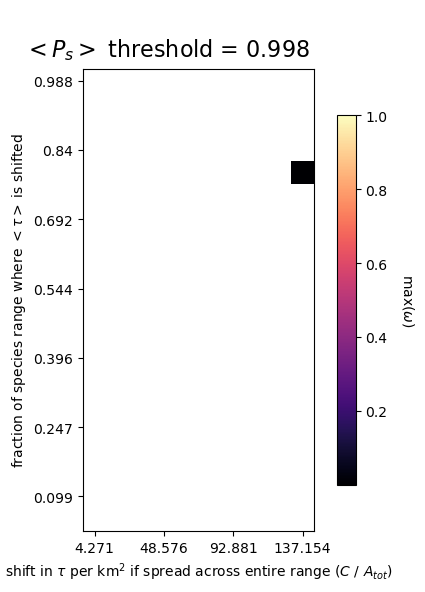

In [9]:
fig, axes = plt.subplots(1, figsize=(6,6))
ax_fontsize = 10
cmap = copy.copy(matplotlib.cm.magma)
vmax = max(maxrob.flatten())
vmin = min(maxrob.flatten())
im1 = axes.imshow(np.flip(maxrob[0].T, axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
cbar = axes.figure.colorbar(im1, ax=axes, location="right", shrink=0.8)
cbar.set_label(fr'$\text{{max}}(\omega)$', 
               rotation=-90, fontsize=ax_fontsize, labelpad=20)

def update(frame):
    if len(tauc_methods) == 1:
        im_vec = [im1]
    for im_i, im in enumerate(im_vec):
        im.set_array(np.flip(maxrob[frame].T, axis=0))
        ytick_spacing = 3
        yticks = np.arange(0, len(ncell_vec), ytick_spacing)
        if im_i == 0:
            ytick_labels = np.flip(ncell_vec / ncell_tot)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
            im.axes.set_ylabel(r'fraction of species range where $<\tau>$ is shifted', fontsize=ax_fontsize)
        else:
            im.axes.set_yticks(yticks, labels=[]);
        xtick_spacing = 3
        xticks = np.arange(0,len(C_vec),xtick_spacing)
        if (len(tauc_methods)==1) or (im_i == 1):
            im.axes.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot*A_cell))[::xtick_spacing], 3));
            im.axes.set_xlabel(r"shift in $\tau$ per $\text{km}^2$ if spread across entire range $({C}~/~{A_{tot}})$", fontsize=ax_fontsize)
        else:
            im.axes.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot*A_cell))[::xtick_spacing], 3));
    fig.suptitle(f"\n{metric_lab} threshold = {np.round(rob_thresh_vec[frame], 3)}", fontsize=16)
    return im_vec

frames = len(rob_thresh_vec)
ani = animation.FuncAnimation(
    fig, update, frames=frames,
    blit=True, interval=100  # interval is time between frames in milliseconds
)
anifn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/robustness.mp4"
ani.save(anifn, writer='ffmpeg', fps=10)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
colormap = copy.copy(matplotlib.cm.magma)
vmax = max(C_vec); vmin = min(C_vec)
normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
colors = colormap(normalize(C_vec))
for C_i, C in enumerate(C_vec):
    plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        # Get the maximum robustness across (ncell, sl) at this C (maximized over sl above)
        maxrob_slice = maxrob[thresh_i, C_i, :]
        if not np.all(np.isnan(maxrob_slice)):
            plot_vec[thresh_i] = (np.nanmax(maxrob_slice))
    ax.plot(rob_thresh_vec, plot_vec, color=colors[C_i])
    scatter = ax.scatter(rob_thresh_vec, plot_vec, 
                         # color=colors[C_i], 
                         cmap=colormap, norm=normalize,
                        c=np.repeat(C, len(rob_thresh_vec)))
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(fr"$C$", rotation=-90, fontsize=ax_fontsize, labelpad=20)
ax.set_ylabel(fr"$\text{{max}}(\omega)$")
ax.set_xlabel(fr"{metric_lab} requirement")
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/optmetric.png"
# fig.savefig(fn, bbox_inches='tight')

In [13]:
def eps_pairplot(C_i, ncell_i, sl_i):
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    eps_keys = list(eps_axes.keys())
    eps_labels = ["$\mu_\tau$", "$\mu_{\tau^*}$", "$\sigma_\tau$", "$\sigma_{\tau^*}$"]
    for row, col in product(range(3), range(3)):
        if [row, col] in [[1,0],[2,0],[2,1]]: 
            axes[row,col].set_yticks([], [])
            axes[row,col].set_xticks([], [])
            continue
        eps_ax_pair = [row, col+1]
        other_eps_axes = [i for i in range(4) if i not in eps_ax_pair]
        phase_slice = phase_full[..., C_i, ncell_i, sl_i]
        slice_means = np.nanmean(phase_slice, axis=tuple(other_eps_axes))
        axes[row,col].imshow(slice_means)
        axes[row,col].set_ylabel(eps_keys[row])
        axes[row,col].set_xlabel(eps_keys[col+1])
        eps_y = eps_axes[eps_keys[row]]
        axes[row,col].set_yticks(np.arange(len(eps_y)), labels=np.round(eps_y, 2))
        xtick_spacing = 2
        eps_x = eps_axes[eps_keys[col+1]]
        axes[row,col].set_xticks(np.arange(len(eps_x))[::xtick_spacing], labels=np.round(eps_x, 2)[::xtick_spacing])
interact(eps_pairplot,
         C_i = widgets.IntSlider(min=0, max=9, step=1, value=0),
         ncell_i = widgets.IntSlider(min=0, max=9, step=1, value=0),
         sl_i = widgets.IntSlider(min=0, max=len(slice_left_all)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='C_i', max=9), IntSlider(value=0, description='ncell_i', …

<function __main__.eps_pairplot(C_i, ncell_i, sl_i)>

## Phase with fri uncertainty

In [ ]:
metric = "lambda_s"
metric_lab = '$<\lambda>$'
# metric = "r"
# metric_lab = '$<r>$'
# metric = "mu_s"
# metric_lab = '$<\mu>$'
# metric = "P_s"
# metric_lab = '$<P_s>$'
Aeff = 1.0
t_final = 600
A_cell = 270**2 / 1e6 #km^2
ncell_tot = 87_993 #should read this in
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
delta_tau_vec = np.load(fn_prefix + "delta_tau_vec.npy")
C_vec = np.load(fn_prefix + "C_vec.npy")
tauc_range_avg = C_vec / ncell_tot
ncell_vec = np.load(fn_prefix + "ncell_vec.npy")
alteration_areas = ncell_vec * A_cell
slice_left_all = np.load(fn_prefix + "slice_left_all.npy")
tauc_methods = ["flat", "initlinear", "initinverse"]
# tauc_methods = ["flat", "initlinear"]
# print(full_phase.shape)
# print("delta_tau, C, ncell, tau_i")

ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
total_cells = np.count_nonzero(((sdm > 0) & (fdm > 0)).flatten())

In [ ]:
delta_zero_i = np.nonzero(delta_tau_vec == 0)[0][0]
delta_tau_step = np.unique(np.diff(delta_tau_vec))[0]
'''Could set these limits based on metric bounds at delta_tau=0'''
# dmin, dmax = (0.76, 0.96)
# dmin, dmax = (min(full_phase[delta_zero_i].flatten()), max(full_phase[delta_zero_i].flatten()))
dmin_all, dmax_all = [], []
for tauc_method_i, tauc_method in enumerate(tauc_methods):
    full_phase = np.load(fn_prefix + f"phase_{tauc_method}.npy")
    dmin, dmax = (min(full_phase.flatten()), max(full_phase[delta_zero_i].flatten()))
    dmin_all.append(dmin)
    dmax_all.append(dmax)
dmin = min(dmin_all); dmax = max(dmax_all)
thresh_vec_rob = np.linspace(dmin, dmax, 100)
# Initialize data for the max robustness per (C, ncell, threshold, fric_method) combination
robustness_all = np.ones((len(tauc_methods), len(thresh_vec_rob), len(ncell_vec), len(C_vec))) * np.nan
for tauc_method_i, tauc_method in enumerate(tauc_methods):
    full_phase = np.load(fn_prefix + f"phase_{tauc_method}.npy")
    for thresh_i, thresh in enumerate(thresh_vec_rob):
        robustness = np.ones((len(ncell_vec), len(C_vec))) * np.nan
        for i, j in itertools.product(range(robustness.shape[0]), range(robustness.shape[1])):
            # Take slice of full_phase at (C, ncell) with axes (delta_tau, tau_i)
            phase_slice = full_phase[:, j, i, :]

            '''Should set a tolerance for how much lower than threshold, rather than hard limit'''
            gt_thresh_counts = np.ones_like(slice_left_all)*np.nan
            for sl_i, slice_left in enumerate(slice_left_all):
                # First check that threshold is met with delta_tau=0
                # If threshold not met at zero uncertainty, this outcome is infeasible
                # Keep robustness of such outcomes as nan
                delta_zero_check1 = np.isnan(phase_slice[delta_zero_i, sl_i])
                delta_zero_check2 = (phase_slice[delta_zero_i, sl_i] < thresh)
                if delta_zero_check1 or delta_zero_check2: continue
                # Check delta_tau < 0
                lt_check = phase_slice[:delta_zero_i, sl_i] < thresh
                lt_check = np.flip(lt_check)
                count_left = np.nonzero(lt_check)[0][0] if np.any(lt_check) else len(lt_check)
                # Then check delta_tau > 0
                lt_check = phase_slice[delta_zero_i+1:, sl_i] < thresh
                count_right = np.nonzero(lt_check)[0][0] if np.any(lt_check) else len(lt_check)
                # Use the minimum to calculate robustness
                # This gives us a bound on the absolute value of delta_tau
                # Not a directional bound
                count = min([count_left, count_right])
                gt_thresh_counts[sl_i] = count
            # Keep robustness at nan if outcome never feasible, regardless of tau_i
            if np.any(~np.isnan(gt_thresh_counts)):
                robustness[i,j] = np.nanmax(gt_thresh_counts) * delta_tau_step

        robustness_all[tauc_method_i, thresh_i] = robustness

In [ ]:
fig, axes = plt.subplots(1, len(tauc_methods), figsize=(6*len(tauc_methods),6))
ax_fontsize = 10
# cmap = copy.copy(matplotlib.cm.jet_r)
cmap = copy.copy(matplotlib.cm.magma)
vmax = max(robustness_all.flatten())
if len(tauc_methods) == 1:
    im1 = axes.imshow(np.flip(robustness_all[0][0], axis=0), cmap=cmap, vmin=0, vmax=vmax)
    cbar = axes.figure.colorbar(im1, ax=axes, location="right", shrink=0.8)
    im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
if len(tauc_methods) > 1:
    im1 = axes[0].imshow(np.flip(robustness_all[0][0], axis=0), cmap=cmap, vmin=0, vmax=vmax)
    cbar = axes[0].figure.colorbar(im1, ax=axes[0], location="right", shrink=0.8)
    im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
    im2 = axes[1].imshow(np.flip(robustness_all[1][0], axis=0), cmap=cmap, vmin=0, vmax=vmax)
    cbar = axes[1].figure.colorbar(im2, ax=axes[1], location="right", shrink=0.8)
    im2.axes.set_title(f"tauc_method={tauc_methods[1]}")
if len(tauc_methods) > 2:
    im3 = axes[2].imshow(np.flip(robustness_all[2][0], axis=0), cmap=cmap, vmin=0, vmax=vmax)
    cbar = axes[2].figure.colorbar(im3, ax=axes[2], location="right", shrink=0.8)
    im3.axes.set_title(f"tauc_method={tauc_methods[2]}")
cbar.set_label(fr'max tolerable $|\Delta\tau|$ while {metric_lab} above threshold [$years$]', 
               rotation=-90, fontsize=ax_fontsize, labelpad=20)

def update(frame):
    if len(tauc_methods) == 1:
        im_vec = [im1]
    elif len(tauc_methods) == 2:
        im_vec = [im1, im2]
    else:
        im_vec = [im1, im2, im3]
    for im_i, im in enumerate(im_vec):
        im.set_array(np.flip(robustness_all[im_i][frame], axis=0))
        # im.axes.set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[frame], 3)}")
        # axes[im_i].set_aspect(0.4)
        ytick_spacing = 3
        yticks = np.arange(0,len(ncell_vec),ytick_spacing)
        if im_i == 0:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
            im.axes.set_ylabel(r'fraction of species range where $<\tau>$ is altered', fontsize=ax_fontsize)
        else:
            im.axes.set_yticks(yticks, labels=[]);
        xtick_spacing = 3
        xticks = np.arange(0,len(C_vec),xtick_spacing)
        if (len(tauc_methods)==1) or (im_i == 1):
            # im.axes.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
            # im.axes.set_xlabel(r'cummulative alteration to $<\text{tau}>$ across species range [$years$]'+'\n', fontsize=ax_fontsize)
            im.axes.set_xticks(xticks, labels=np.round((C_vec/ncell_tot)[::xtick_spacing], 3));
            im.axes.set_xlabel(r'would be $<\tau>$ alteration per cell spread across entire species range [$years$]', fontsize=ax_fontsize)
        else:
            im.axes.set_xticks(xticks, labels=np.round((C_vec/ncell_tot)[::xtick_spacing], 3));
    fig.suptitle(f"\n{metric_lab} threshold = {np.round(thresh_vec_rob[frame], 3)}", fontsize=16)
    return im_vec

frames = len(thresh_vec_rob)
# frames = range(int(len(thresh_vec_rob)/2), int(len(thresh_vec_rob)/2)+1)
ani = animation.FuncAnimation(
    fig, update, frames=frames,
    blit=True, interval=100  # interval is time between frames in milliseconds
)
anifn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/robustness.mp4"
ani.save(anifn, writer='ffmpeg', fps=10)

Make similar viz but put delta_tau threshold on slider and color by max($<\lambda>$), with max taken over $\tau_i$. At each $\tau_i$, take the min($<\lambda>$) while $|\Delta{\tau}| <= threshold$ is satisfied. So, color by the 'best-worst' case scenario for $<\lambda>$ under a given $|\Delta{\tau}|$ threshold (aka "horizon of uncertainty" in info-gap). 

Implicit assumption here is that min$(<\lambda>(C,n_{cell},\tau_i))$ decreases monotonically with increasing $|\Delta{\tau}|$ threshold, which is fairly safe, but might want to look into that more. 

In [ ]:
delta_zero_i = np.nonzero(delta_tau_vec == 0)[0][0]
delta_tau_step = np.unique(np.diff(delta_tau_vec))[0]
thresh_vec_maxlam = delta_tau_vec[delta_tau_vec >= 0]
# Initialize data for the max(<lam>) per (C, ncell, threshold) combination
maxlam_all = np.ones((len(tauc_methods), len(thresh_vec_maxlam), len(ncell_vec), len(C_vec))) * np.nan
for tauc_method_i, tauc_method in enumerate(tauc_methods):
    full_phase = np.load(fn_prefix + f"phase_{tauc_method}.npy")
    nochange_all = np.ones_like(thresh_vec_maxlam) * np.nan
    all_maxes = np.ones_like(thresh_vec_maxlam) * np.nan
    for thresh_i, thresh in enumerate(thresh_vec_maxlam):
        maxlam = np.ones((len(ncell_vec), len(C_vec))) * np.nan
        for i, j in itertools.product(range(maxlam.shape[0]), range(maxlam.shape[1])):
            # Take slice of full_phase at (C, ncell) with axes (delta_tau, tau_i)
            phase_slice = full_phase[:, j, i, :]
            # Create filter for delta_tau axis
            delta_tau_filt = (delta_tau_vec >= -thresh) & (delta_tau_vec <= thresh)
            minlam_per_sl = np.ones_like(slice_left_all)*np.nan
            for sl_i, slice_left in enumerate(slice_left_all):
            # for sl_i, slice_left in enumerate(slice_left_all[40:41]):
                within_thresh = phase_slice[delta_tau_filt, sl_i]
                # Check that <lam> was computed for this (C,ncell,tau_i)
                if np.all(np.isnan(within_thresh)): continue
                # Take the worst case scenario (i.e. min(<lam>)) within uncertainty threshold
                minlam_per_sl[sl_i] = np.nanmin(within_thresh)
            # Now store the best possible lower bound on <lam>
            # Keep at nan if no <lam> computed at this (C,ncell) (this shouldn't happen)
            if np.any(~np.isnan(minlam_per_sl)):
                maxlam[i,j] = np.nanmax(minlam_per_sl)
            else:
                print(f"hey, no samples at C={C_vec[i]}, ncell={ncell_vec[j]}")
        maxlam_all[tauc_method_i, thresh_i] = maxlam

        # Also store nochange value
        mindelta_i = np.nonzero(delta_tau_vec == -thresh)[0][0]
        nochangefn = fn_prefix+f"deltatau_{delta_tau_vec[mindelta_i]}/nochange_{tauc_method}.json"
        with open(nochangefn, 'r') as handle:
            nochange = json.load(handle)[f'{metric}_expect_nochange']
        nochange_all[thresh_i] = nochange

        # Pre-process the maximum's per threshold for plotting as well
        all_maxes[thresh_i] = np.nanmax(maxlam.flatten())

In [ ]:
fig, axes = plt.subplots(1, len(tauc_methods), figsize=(6*len(tauc_methods),6))
ax_fontsize = 10
cmap = copy.copy(matplotlib.cm.magma)
vmax = np.nanmax(maxlam_all.flatten())
vmin = np.nanmin(maxlam_all.flatten())
if len(tauc_methods) == 1:
    im1 = axes.imshow(np.flip(maxlam_all[0][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes.figure.colorbar(im1, ax=axes, location="right", shrink=0.8)
    im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
if len(tauc_methods) > 1:
    im1 = axes[0].imshow(np.flip(maxlam_all[0][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes[0].figure.colorbar(im1, ax=axes[0], location="right", shrink=0.8)
    im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
    im2 = axes[1].imshow(np.flip(maxlam_all[1][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes[1].figure.colorbar(im2, ax=axes[1], location="right", shrink=0.8)
    im2.axes.set_title(f"tauc_method={tauc_methods[1]}")
if len(tauc_methods) > 2:
    im3 = axes[2].imshow(np.flip(maxlam_all[2][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes[2].figure.colorbar(im3, ax=axes[2], location="right", shrink=0.8)
    im3.axes.set_title(f"tauc_method={tauc_methods[2]}")
cbar.set_label(fr"maximum {metric_lab} robust to $|\Delta\tau|$", rotation=-90, fontsize=ax_fontsize, labelpad=20)

def update(frame):
    if len(tauc_methods) == 1:
        im_vec = [im1]
    elif len(tauc_methods) == 2:
        im_vec = [im1, im2]
    else:
        im_vec = [im1, im2, im3]
    for im_i, im in enumerate(im_vec):
        im.set_array(np.flip(maxlam_all[im_i][frame], axis=0))
        # im.axes.set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[frame], 3)}")
        # axes[im_i].set_aspect(0.4)
        ytick_spacing = 3
        yticks = np.arange(0,len(ncell_vec),ytick_spacing)
        if im_i == 0:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
            im.axes.set_ylabel(r'fraction of species range where $<\tau>$ is altered', fontsize=ax_fontsize)
        else:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=[]);
        xtick_spacing = 3
        xticks = np.arange(0,len(C_vec),xtick_spacing)
        # im.axes.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
        # im.axes.set_xlabel(r'cummulative alteration to $<\tau>$ across species range [$years$]')
        if (len(tauc_methods)==1) or (im_i == 1):
            # im.axes.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
            # im.axes.set_xlabel(r'cummulative alteration to $<\text{tau}>$ across species range [$years$]'+'\n', fontsize=ax_fontsize)
            im.axes.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot*A_cell))[::xtick_spacing], 0));
            # im.axes.set_xlabel(r'would be $<\tau>$ alteration per cell spread across entire species range [$years$]', fontsize=ax_fontsize)
            im.axes.set_xlabel(r'would be $<\tau>$ alteration per km^2 spread across entire species range [$years$]', fontsize=ax_fontsize)
        else:
            im.axes.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot*A_cell))[::xtick_spacing], 0));
    fig.suptitle("\n" + r"$|\Delta\tau|$ threshold = " + f"{np.round(thresh_vec_maxlam[frame], 3)}", fontsize=16)
    return im_vec

ani = animation.FuncAnimation(
    fig, update, frames=len(thresh_vec_maxlam), blit=True, interval=100  # interval is time between frames in milliseconds
)
anifn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/maxlam.mp4"
ani.save(anifn, writer='ffmpeg', fps=10)

In [ ]:
fig, axes = plt.subplots(1, len(tauc_methods), figsize=(9*len(tauc_methods),7))
ax_fontsize = 12
# Get all available marker styles from Line2D
# all_markers = list(matplotlib.lines.Line2D.markers.keys())
all_markers = ['.','o','s','D','^']
all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
colormap = copy.copy(matplotlib.cm.magma)
vmax = np.nanmax(maxlam_all.flatten())
vmin = np.nanmin(maxlam_all.flatten())
normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
# Specify values of uncertainty threshold at which to plot optimal ncell
delta_tau_samples = np.arange(0,12,2.5)
delta_tau_samples = np.arange(0,10,3)
for tauc_method_i, tauc_method in enumerate(tauc_methods):
    maxlam = maxlam_all[tauc_method_i]
    optncell_vec = []
    for delta_tau_i, delta_tau in enumerate(delta_tau_samples):
        # Get the optimal ncell values at each C value
        thresh_i = np.nonzero(thresh_vec_maxlam == delta_tau)[0][0]
        # optncell_i = np.argmax(maxlam[delta_tau_i].max(axis=0))
        # optncell_vec.append(ncell_vec[optncell_i])
        optncell_i_vec = maxlam[thresh_i].argmax(axis=0)
        optncell_vec = ncell_vec[optncell_i_vec]
        # Also get the optimal metric values robust to |Deltatau|
        optmetric_vec = maxlam[thresh_i, optncell_i_vec, np.arange(len(C_vec))]
        marker = all_markers[delta_tau_i]
        # axes[tauc_method_i].scatter(C_vec, (optncell_vec/total_cells), marker=marker, label=rf"$|\Delta\tau|$={delta_tau}")
        # axes[tauc_method_i].scatter(C_vec, optncell_vec, marker=marker, label=rf"$|\Delta\tau|$={delta_tau}")
        axes[tauc_method_i].plot((C_vec/(ncell_tot*A_cell)), (optncell_vec/total_cells), ls=all_linestyles[delta_tau_i], c='k', zorder=-1)
        scatter = axes[tauc_method_i].scatter((C_vec/(ncell_tot*A_cell)), (optncell_vec/total_cells), marker=marker, 
                                     label=rf"$|\Delta\tau|$={delta_tau}", cmap=colormap, norm=normalize, c=optmetric_vec)
    axes[tauc_method_i].set_title(f"tauc_method={tauc_method}")
    axes[tauc_method_i].legend()
    # if tauc_method_i == 0:
    if True:
        axes[tauc_method_i].set_ylabel(r'optimal fraction of range where $<\tau>$ is shifted', fontsize=ax_fontsize)
    axes[tauc_method_i].set_ylim(0,1)
    # axes[tauc_method_i].set_xlabel(r'would be $<\tau>$ alteration per km^2 spread'+'\n'+'across entire species range [$years$]', fontsize=ax_fontsize)
    axes[tauc_method_i].set_xlabel(r"shift in $\tau$ per $\text{km}^2$ if spread across entire range $({C}~/~{A_{tot}})$", fontsize=ax_fontsize)
    # if tauc_method_i == (len(tauc_methods) - 1): 
    cbar = fig.colorbar(scatter, ax=axes[tauc_method_i], location="right", shrink=0.8)
    cbar.set_label(fr"maximum {metric_lab} robust to $|\Delta\tau|$", rotation=-90, fontsize=ax_fontsize, labelpad=20)
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/optncell.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1, len(tauc_methods), figsize=(9*len(tauc_methods),7))

# Specify values of uncertainty threshold at which to plot optimal ncell
delta_tau_samples = np.arange(0,12,2)

ax_fontsize = 12
# Get all available marker styles from Line2D
# all_markers = list(matplotlib.lines.Line2D.markers.keys())
# all_markers = ['.','o','s','D','^']
# all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
colormap = copy.copy(matplotlib.cm.magma)
vmax = max(thresh_vec_maxlam)
vmin = min(thresh_vec_maxlam)
normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
colors = colormap(normalize(delta_tau_samples))

for tauc_method_i, tauc_method in enumerate(tauc_methods):
    maxlam = maxlam_all[tauc_method_i]
    optncell_vec = []
    for delta_tau_i, delta_tau in enumerate(delta_tau_samples):
        # Get the optimal ncell values at each C value
        thresh_i = np.nonzero(thresh_vec_maxlam == delta_tau)[0][0]
        # Get the optimal metric values robust to |Deltatau|
        optmetric_vec = maxlam[thresh_i].max(axis=0)
        # marker = all_markers[delta_tau_i]
        axes[tauc_method_i].plot((C_vec/(ncell_tot*A_cell)), optmetric_vec, c=colors[delta_tau_i], zorder=-1)
        scatter = axes[tauc_method_i].scatter((C_vec/(ncell_tot*A_cell)), optmetric_vec, cmap=colormap, 
                                              norm=normalize, c=np.repeat(delta_tau, len(optmetric_vec)))
    axes[tauc_method_i].set_title(r"tauc_method={tauc_method}")
    # axes[tauc_method_i].legend()
    # if tauc_method_i == 0:
    if True:
        axes[tauc_method_i].set_ylabel(fr'optimal {metric_lab} robust to $|\Delta\tau|$', fontsize=ax_fontsize)
    # axes[tauc_method_i].set_ylim(0,1)
    axes[tauc_method_i].set_ylim(min(maxlam_all.flatten()),max(maxlam_all.flatten()))
    # axes[tauc_method_i].set_xlabel(r'would be $<\tau>$ alteration per km^2 spread'+'\n'+'across entire species range [$years$]', fontsize=ax_fontsize)
    axes[tauc_method_i].set_xlabel(r"shift in $\tau$ per $\text{km}^2$ if spread across entire range $({C}~/~{A_{tot}})$", fontsize=ax_fontsize)
    # if tauc_method_i == (len(tauc_methods) - 1): 
    cbar = fig.colorbar(scatter, ax=axes[tauc_method_i], location="right", shrink=0.8)
    cbar.set_label(fr"$|\Delta\tau|$ threshold", rotation=-90, fontsize=ax_fontsize, labelpad=20)
fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/optmetric.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
# Get tau raster
maps_filt = (sdm > 0) & (fdm > 0)
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
tau_flat = fri_raster[maps_filt]
tau_argsort_ref = np.argsort(tau_flat)
tau_sorted = tau_flat[tau_argsort_ref] 

delta_zero_i = np.nonzero(delta_tau_vec == 0)[0][0]
delta_tau_step = np.unique(np.diff(delta_tau_vec))[0]
thresh_vec_opttau = delta_tau_vec[delta_tau_vec >= 0]
opttau_all = np.ones((len(tauc_methods), len(thresh_vec_opttau), len(ncell_vec), len(C_vec))) * np.nan
for tauc_method_i, tauc_method in enumerate(tauc_methods):
    full_phase = np.load(fn_prefix + f"phase_{tauc_method}.npy")
    nochange_all = np.ones_like(thresh_vec_opttau) * np.nan
    for thresh_i, thresh in enumerate(thresh_vec_opttau):
        opttau = np.ones((len(ncell_vec), len(C_vec))) * np.nan
        for i, j in itertools.product(range(opttau.shape[0]), range(opttau.shape[1])):
            # Take slice of full_phase at (C, ncell) with axes (delta_tau, tau_i)
            phase_slice = full_phase[:, j, i, :]
            # Create filter for delta_tau axis
            delta_tau_filt = (delta_tau_vec >= -thresh) & (delta_tau_vec <= thresh)
            minmet_per_sl = np.ones_like(slice_left_all)*np.nan
            for sl_i, slice_left in enumerate(slice_left_all):
                within_thresh = phase_slice[delta_tau_filt, sl_i]
                # Check that <metric> was computed for this (C,ncell,tau_i)
                if np.all(np.isnan(within_thresh)): continue
                # Take the worst case scenario (i.e. min(<metric>) at tau_i) within uncertainty threshold
                minmet_per_sl[sl_i] = np.nanmin(within_thresh)
            # Now find the best possible lower bound on <metric>
            # All of these lower bounds are robust to |Delta_tau|, we want to maximize   
            # metric while maintaining robustness
            # maxmet[i,j] = np.nanmax(minmet_per_sl)
            max_robust_met = np.nanmax(minmet_per_sl)
            # Find and store the <tau> of the optimal slice
            optimal_sl_i = np.argwhere(minmet_per_sl == max_robust_met)[0][0]
            optimal_sl = slice_left_all[optimal_sl_i]
            tau_slice = tau_sorted[optimal_sl:optimal_sl+ncell_vec[i]]
            opttau[i,j] = np.mean(tau_slice)
        opttau_all[tauc_method_i, thresh_i] = opttau

        # Also store nochange value
        mindelta_i = np.nonzero(delta_tau_vec == -thresh)[0][0]
        nochangefn = fn_prefix+f"deltatau_{delta_tau_vec[mindelta_i]}/nochange_{tauc_method}.json"
        with open(nochangefn, 'r') as handle:
            nochange = json.load(handle)[f'{metric}_expect_nochange']
        nochange_all[thresh_i] = nochange

In [ ]:
fig, axes = plt.subplots(1, len(tauc_methods), figsize=(6*len(tauc_methods),6))
ax_fontsize = 10
cmap = copy.copy(matplotlib.cm.magma)
vmax = np.nanmax(opttau_all.flatten())
vmin = np.nanmin(opttau_all.flatten())
if len(tauc_methods) == 1:
    im1 = axes.imshow(np.flip(opttau_all[0][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes.figure.colorbar(im1, ax=axes, location="right", shrink=0.8)
    im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
if len(tauc_methods) > 1:
    im1 = axes[0].imshow(np.flip(opttau_all[0][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes[0].figure.colorbar(im1, ax=axes[0], location="right", shrink=0.8)
    im1.axes.set_title(f"tauc_method={tauc_methods[0]}")
    im2 = axes[1].imshow(np.flip(opttau_all[1][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes[1].figure.colorbar(im2, ax=axes[1], location="right", shrink=0.8)
    im2.axes.set_title(f"tauc_method={tauc_methods[1]}")
if len(tauc_methods) > 2:
    im3 = axes[2].imshow(np.flip(opttau_all[2][0], axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = axes[2].figure.colorbar(im3, ax=axes[2], location="right", shrink=0.8)
    im3.axes.set_title(f"tauc_method={tauc_methods[2]}")
cbar.set_label(fr"$<\tau>$ where max {metric_lab} robust to $|\Delta\tau|$ achieved", rotation=-90, fontsize=ax_fontsize, labelpad=20)

def update(frame):
    if len(tauc_methods) == 1:
        im_vec = [im1]
    elif len(tauc_methods) == 2:
        im_vec = [im1, im2]
    else:
        im_vec = [im1, im2, im3]
    for im_i, im in enumerate(im_vec):
        im.set_array(np.flip(opttau_all[im_i][frame], axis=0))
        # im.axes.set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[frame], 3)}")
        # axes[im_i].set_aspect(0.4)
        ytick_spacing = 3
        yticks = np.arange(0,len(ncell_vec),ytick_spacing)
        if im_i == 0:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
            im.axes.set_ylabel(r'fraction of species range where $<\tau>$ is altered', fontsize=ax_fontsize)
        else:
            ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
            im.axes.set_yticks(yticks, labels=[]);
        xtick_spacing = 3
        xticks = np.arange(0,len(C_vec),xtick_spacing)
        # im.axes.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
        # im.axes.set_xlabel(r'cummulative alteration to $<\tau>$ across species range [$years$]')
        if (len(tauc_methods)==1) or (im_i == 1):
            # im.axes.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
            # im.axes.set_xlabel(r'cummulative alteration to $<\text{tau}>$ across species range [$years$]'+'\n', fontsize=ax_fontsize)
            im.axes.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot*A_cell))[::xtick_spacing], 0));
            # im.axes.set_xlabel(r'would be $<\tau>$ alteration per cell spread across entire species range [$years$]', fontsize=ax_fontsize)
            im.axes.set_xlabel(r'would be $<\tau>$ alteration per km^2 spread across entire species range [$years$]', fontsize=ax_fontsize)
        else:
            im.axes.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot*A_cell))[::xtick_spacing], 0));
    fig.suptitle("\n" + r"$|\Delta\tau|$ threshold = " + f"{np.round(thresh_vec_opttau[frame], 3)}", fontsize=16)
    return im_vec

ani = animation.FuncAnimation(
    fig, update, frames=len(thresh_vec_opttau), blit=True, interval=100  # interval is time between frames in milliseconds
)
anifn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/opttau.mp4"
ani.save(anifn, writer='ffmpeg', fps=10)

### Checking results relative to nochange

In [ ]:
plt.hist(full_phase.flatten(), bins=50);
plt.axvline(min(nochange_all), ls='--', c='k')

In [ ]:
axis_labels = ["delta_tau", "C", "ncell", "tau_i"]
problem_indicies = np.argwhere(full_phase < min(nochange_all))
# for pi in problem_indicies:
#     print(pi)
# Where are these problems happening most often? Check each dimension
for axis in range(problem_indicies.shape[-1]):
    plt.hist(problem_indicies[:, axis])
    plt.title(axis_labels[axis])
    plt.show()

In [ ]:
delta_tau_filt = np.nonzero((problem_indicies[:,0] == 0) #delta_tau
                            & (problem_indicies[:,1] == 4) #C
                            & (problem_indicies[:,2] == 12) #ncell
                            # & (problem_indicies[:,3] == 82) #slice_left_i
                            )[0]
plt.hist(problem_indicies[delta_tau_filt,3]);

In [ ]:
tau_max_all = np.load(fn_prefix+"tau_max_all.npy")
delta_tau = -10.0
for C in C_vec:
    # C = C_vec[4]
    nochangefn = fn_prefix+f"deltatau_{delta_tau}/const_{C}/metric_lambda_s/nochange.json"
    print(nochangefn)
    with open(nochangefn, 'r') as handle:
        nochange = json.load(handle)['lambda_s_expect_nochange']
    phasefn = fn_prefix+f"deltatau_{delta_tau}/const_{C}/metric_lambda_s/phase_scaledtoinit.npy"
    phase_space = np.load(phasefn)
    metric='lambda_s'
    fig, ax = plt.subplots(figsize=(12,12))
    phase_space = np.ma.masked_where(np.isnan(phase_space),  phase_space)
    phase_flat = phase_space.flatten()
    cmap = copy.copy(matplotlib.cm.plasma)
    if len(phase_flat[phase_flat != np.ma.masked]) == 0:
        phase_max = 0
    else:
        '''doing this for now bc some runs are bad'''
        if (metric=='r') or (metric=='g'):
            phase_max = np.quantile(phase_flat[phase_flat != np.ma.masked], 0.98)
        if metric in ['Nf', 'xs', 'mu_s', 'lambda_s']:
            phase_max = max(phase_flat[phase_flat != np.ma.masked])
            phase_min = min(phase_flat[phase_flat != np.ma.masked])
    cmap.set_bad('white')
    im = ax.imshow(phase_space, norm=matplotlib.colors.Normalize(vmin=phase_min, vmax=phase_max), cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
    cbar.ax.set_ylabel(r'$<{}>$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
    cbar.ax.axhline(nochange, color='white', linewidth=2)

### Using interact

In [ ]:
def plt_robustness(thresh_i=0):
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = copy.copy(matplotlib.cm.jet_r)
    # cmap = copy.copy(matplotlib.cm.cool_r)
    # cmap = copy.copy(matplotlib.cm.plasma)
    vmax = max(robustness_all.flatten())
    im = ax.imshow(np.flip(robustness_all[thresh_i], axis=0), cmap=cmap, vmin=0, vmax=vmax)
    ax.set_aspect(0.4)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.7)
    cbar.set_label(r'max tolerable $\Delta{\text{tau}}$ while $<\lambda>$ above threshold [$years$]', rotation=-90, fontsize=10, labelpad=20)
    # ytick_spacing = 2
    # ytick_labels = np.round(np.flip(alteration_areas)[::ytick_spacing]).astype(int)
    # yticks = np.arange(0,len(alteration_areas),ytick_spacing)
    # ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    # ax.set_ylabel(r'geographic area where $<\text{tau}>$ is altered [$km^2$]')
    ytick_spacing = 2
    ytick_labels = np.flip(ncell_vec / total_cells)[::ytick_spacing]
    yticks = np.arange(0,len(ncell_vec),ytick_spacing)
    ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    ax.set_ylabel(r'fraction of species range where $<\text{tau}>$ is altered')
    xtick_spacing = 1
    xticks = np.arange(0,len(C_vec),xtick_spacing)
    ax.set_xticks(xticks, labels=C_vec[::xtick_spacing]);
    ax.set_xlabel(r'cummulative alteration to $<\text{tau}>$ across species range [$years$]')
    ax.set_title(f"$<\lambda>$ threshold = {np.round(thresh_vec_rob[thresh_i], 3)}")
    
interact(plt_robustness, thresh_i=(0, len(thresh_vec_rob)-1, 1))

### Looking at max(<$\lambda$>) across $\tau_i$

In [ ]:
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/delta_fri_phase_{fric_method}.npy"
# fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/scaledfric_delta_fri_phase.npy"
data = np.load(fn)
print(data.shape)
print("(constraint, n_cell, delta_fri)")

In [ ]:
metric = 'lambda_s'
for i in range(data.shape[2]):
    if delta_fri_vec[i] != 0: continue
    fig, ax = plt.subplots(figsize=(5,5))#(10,14))
    cmap = copy.copy(matplotlib.cm.plasma)
    data_slice = np.swapaxes(data[:, :, i], 0, 1)
    im = ax.imshow(np.flip(data_slice, 0), cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.5)
    cbar.ax.set_ylabel(r'$max(<\{}>)$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
    ytick_spacing = 2
    ytick_labels = np.flip(ncell_vec)[::ytick_spacing]
    yticks = np.arange(0,len(ncell_vec),ytick_spacing)
    ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    ax.set_ylabel('Number of cells intervened in')
    xtick_spacing = 3
    xticks = np.arange(0,len(constraint_vec),xtick_spacing)
    ax.set_xticks(xticks, labels=np.round(constraint_vec[::xtick_spacing]));
    ax.set_xlabel('C, total fri change across species range')
    ax.set_title(f'delta_fri={delta_fri_vec[i]}')
    # fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/phase_{metric}_deltafri{delta_fri_sys[i]}.png"
    # fig.savefig(fn, bbox_inches='tight')

In [ ]:
# threshold = 0
# threshold_vec = np.arange(-0.5, 0.75, 0.05)
# threshold_vec = np.arange(-0.04, 0.001, 0.001)
dmin, dmax = (min(data.flatten()), max(data.flatten()))
# dmin, dmax = (0.76, 0.978)
threshstep = (dmax - dmin) / 50
threshold_vec = np.arange(dmin, dmax+threshstep, threshstep)
# z = np.empty((data.shape[0], len(threshold_vec)))
z = np.empty((len(threshold_vec), data.shape[0]))
x, y = np.meshgrid(constraint_vec, threshold_vec)
for thresh_i, threshold in enumerate(threshold_vec):
    Delta_vec = np.empty(data.shape[:-1])
    for const_i in range(data.shape[0]):
        for n_cell_i in range(data.shape[1]):
            # For computing with systematic errors 
            above_thresh_counts = np.count_nonzero(data[const_i, n_cell_i, :] > threshold)
            Delta_fri = above_thresh_counts * (delta_fri_vec[1] - delta_fri_vec[0])
            Delta_vec[const_i, n_cell_i] = Delta_fri
            # For computing with normally distributed errors
            # try:
            #     max_sigma_i = max(np.nonzero(data[const_i, n_cell_i, :] > threshold)[0])
            # except:
            #     max_sigma_i = 0
            # Delta_vec[const_i, n_cell_i] = delta_fri_vec[max_sigma_i]
    # Store the max tolerated uncertainty at each constraint value
    z[thresh_i, :] = np.max(Delta_vec, axis=1)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
fig, ax = plt.subplots(figsize=(8,10))
cmap = copy.copy(matplotlib.cm.jet_r)
im = ax.imshow(np.flip(z, axis=0), cmap=cmap)#, vmin=3, vmax=7)
ax.set_aspect(0.1)
# im = ax.imshow(z, cmap=cmap)
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.5)
cbar.ax.set_ylabel(r'$\Delta{fri}$', rotation=-90, fontsize=10, labelpad=20)
# cbar.ax.set_ylabel(r'$max(\sigma)$', rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 4
ytick_labels = np.flip(threshold_vec)[::ytick_spacing]
yticks = np.arange(0,len(threshold_vec),ytick_spacing)
ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
ax.set_ylabel(f'max(<{metric}>) threshold')
xtick_spacing = 1
xticks = np.arange(0,len(constraint_vec),xtick_spacing)
ax.set_xticks(xticks, labels=constraint_vec[::xtick_spacing]);
ax.set_xlabel('C, total fri change across species range')
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/deltafri_phase_{metric}.png"
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/deltafri_random_phase_{metric}.png"
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/scaledfric_deltafri_phase_{metric}.png"
# fig.savefig(fn, bbox_inches='tight')

In [ ]:
# %matplotlib widget

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, z, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('max(<r>) threshold')
ax.set_xlabel('area where <fif>=1')
ax.set_zlabel(r'$\Delta{fri}$')

## Playing around with metrics

In [ ]:
jobs = project.find_jobs({'Aeff': 1.0, 'method': 'nint'})
job = project.get_job('workspace/a066a04d26bc802ca30a20ad67c57cf4')

sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])

In [ ]:
def recompute_lambda(b, burn_in_end_i, census_t, N_tot):
    nonzero_counts = np.count_nonzero(N_tot, axis=1)
    extirpated_replicas = np.nonzero(nonzero_counts < census_t[-1])[0]

    # First handle replicas where extirpations occur
    lam_s_extir = []
    N_i_extir = []
    for rep_i in extirpated_replicas:
        N_t = N_tot[rep_i]
        zero_i_min = nonzero_counts[rep_i] 
        final_i = zero_i_min
        if (zero_i_min < burn_in_end_i) or ((zero_i_min - burn_in_end_i) < 200):
            start_i = 0
            tooquick = True
        else:
            start_i = burn_in_end_i
            tooquick = False

        t = census_t[start_i:final_i]
        N_slice = N_t[start_i:final_i]
        if tooquick:
            # lam_s_replica = np.exp(-np.log(N_slice[0]) / len(t))
            continue
            # lam_s_replica = np.product(N_slice[1:] / np.roll(N_slice, 1)[1:]) ** (1/len(t))
        else:
            lam_s_replica = np.product(N_slice[1:] / np.roll(N_slice, 1)[1:]) ** (1/len(t))
        lam_s_extir.append(lam_s_replica)
        N_i_extir.append(N_slice[0])

    # Now handle cases with no extirpation
    N_tot = np.delete(N_tot, extirpated_replicas, axis=0)
    start_i = burn_in_end_i
    final_i = N_tot.shape[1]
    N_slice = N_tot[:,start_i:final_i]
    lam_products = np.product(N_slice[:,1:] / np.roll(N_slice, 1, 1)[:,1:], axis=1)
    lam_s_vec = lam_products ** (1/N_slice.shape[1]) 

    lam_s_all = np.concatenate((lam_s_vec, lam_s_extir))
    if len(lam_s_all) != 0:
        lambda_s = np.mean(lam_s_all) 
    else:
        lam_s = np.exp(-np.log(job.sp.Aeff*job.sp.params.K_adult) / len(t))
        lambda_s = lam_s
    N_i = np.concatenate((N_slice[:,0], N_i_extir))
    return lambda_s, lam_s_all, N_i

In [ ]:
def recompute_mu(b, burn_in_end_i, census_t, N_tot_mean):
    zero_is = np.nonzero(N_tot_mean == 0)[0]
    if len(zero_is) > 0:
        if (min(zero_is) < burn_in_end_i) or ((min(zero_is) - burn_in_end_i) < 300):
            start_i = 0
            final_i = min(zero_is)
            tooquick = True
        else:
            start_i = burn_in_end_i
            final_i = min(zero_is)
            tooquick = False
    else:
        start_i = burn_in_end_i
        final_i = len(N_tot_mean)
        tooquick = False

    t = census_t[start_i:final_i]
    N_mean_t = N_tot_mean[start_i:final_i]
    if tooquick:
        #mu_s = -np.log(N_mean_t[0]) / len(t)
        mu_s = np.exp(-np.log(N_mean_t[0]) / len(t))
    else:
        #mu_s = np.sum(np.log(N_mean_t[1:] / np.roll(N_mean_t, 1)[1:])) / len(t)
        mu_s = np.product(N_mean_t[1:] / np.roll(N_mean_t, 1)[1:]) ** (1/len(t))
    return mu_s 

In [ ]:
# Use test trajectory
b = 84
N_tot = np.load("nint_data/N_tot.npy")
census_t = np.load("nint_data/census_t.npy")
tau = np.round(b*gamma(1+1/1.42), 0)

fig, ax = plt.subplots(figsize=(6,4))
thinning = 50
# ax.plot(census_t, N_tot[21], c='red')
for rep in range(N_tot.shape[0])[::thinning]:
    # Plot (thinned) replicas on top of each other
    ax.plot(census_t, N_tot[rep], alpha=min([thinning/1000,1]), c='k')
# Plot average abundance
N_tot_mean = N_tot.mean(axis=0)
ax.plot(census_t, N_tot_mean, c='k', alpha=0.8)
# Plot median abundance
N_tot_median = np.median(N_tot, axis=0)
ax.plot(census_t, N_tot_median, c='orange', alpha=0.8)
ax.axhline(job.sp.params.K_adult*job.sp.Aeff, ls='--')
# Get slices of data post burn in
burn_in_end_i = 0
t_post = census_t[burn_in_end_i:]
t_new = np.arange(len(t_post))
N_mean_post = N_tot_mean[burn_in_end_i:]

# Recompute and plot lambda_s
lambda_s, lam_s_all, N_i = recompute_lambda(b, burn_in_end_i, census_t, N_tot)
ax.plot(t_post, N_mean_post[0] * np.power(lambda_s, t_new), c='lime', label=r'$\lambda$')
'''Should I set the 'extinct' abundance to lt 1? can't be zero...'''
Te_lambda = np.log(1/N_mean_post[0])/np.log(lambda_s) 
ax.axvline(Te_lambda, ls='dashdot', c='lime')
ax.set_yscale('log')
ax.set_ylim(1e0, 1.5e7)
# ax.set_ylim(0, 1)
ax.axvline(600, ls='--')
ax.set_xlim(-50, max(census_t))

# Recompute and plot mu_s
mu_s = recompute_mu(b, burn_in_end_i, census_t, N_tot_mean)
ax.plot(t_post, N_mean_post[0] * np.power(mu_s, t_new), c='magenta', label='$\mu$')
Te_mu = np.log(1/N_mean_post[0])/np.log(mu_s)
print(Te_mu)
ax.axvline(Te_mu, ls='dashdot', c='magenta')

frac_extirpated = np.array([sum(N_tot[:,t_i]==0)/N_tot.shape[0] for t_i in range(len(census_t))])
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(census_t, frac_extirpated)
ax.set_title(rf"$\tau={tau}$", fontsize=20)
ax.axvline(600, ls='--')
ax.axvline(Te_lambda, ls='dashdot', c='lime')
ax.set_xlim(-50, max(census_t))

In [ ]:
# Recompute lambda_s within smaller timeframe 
# lambda_s, lam_s_all, N_i = recompute_lambda(b, burn_in_end_i, census_t[:1000], N_tot[:,:1000])
lambda_s, lam_s_all, N_i = recompute_lambda(b, burn_in_end_i, census_t, N_tot)

# Recompute mu_s within smaller timeframe 
# mu_s = recompute_mu(b, burn_in_end_i, census_t[:1000], N_tot_mean[:1000])
mu_s = recompute_mu(b, 200, census_t[:], N_tot_mean[:])
Te_mu = np.log(1/N_mean_post[0])/np.log(mu_s)
print(Te_mu)

In [ ]:
plt.hist(lam_s_all, bins=40);
plt.axvline(np.mean(lam_s_all), ls='--', c='k')
plt.xlabel(r"individual replica $\lambda$")

In [ ]:
plt.hist(N_i, bins=1000);
plt.xlim(0,0.2e5)
plt.xlabel(r"individual replica $N_i$")
plt.axvline(job.sp.params.K_adult * job.sp.Aeff, ls='--', c='k')

In [ ]:
'''Convert these to time to extinction per replica'''
# Te_lambda_allreps = np.log(1/N_mean_post[0])/np.log(lam_s_all) #need to use actual replica init N
# Need to filter out reps where lambda >= 1 (these will never go extinct)
growth_filt = lam_s_all < 1
Te_lambda_allreps = np.log(1/N_i[growth_filt])/np.log(lam_s_all[growth_filt])
plt.hist(Te_lambda_allreps, bins=1000);
plt.axvline(np.mean(Te_lambda_allreps), ls='dotted', c='lime')
plt.xlim(0,0.2e5)
plt.xlabel(r"individual replica $T_e$")
plt.axvline(np.quantile(Te_lambda_allreps, 0.90), ls='dashdot', c='lime')
'''But for tau values with rare extinctions, how do we compare? 
   Feel like its better to just stick with lambda
   Or could compare probability of extinction by a given t'''
print(np.quantile(Te_lambda_allreps, 0.90))

In [ ]:
np.random.randint(N_tot.shape[0], size=10)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
# thinning = 500
# for rep in range(N_tot.shape[0])[::thinning]:
#     ax.plot(census_t, N_tot[rep])
# filt = N_tot[:, 4999] > 1e6
# for rep in N_tot[filt]:
#     ax.plot(census_t, rep)
nonzero_counts = np.count_nonzero(N_tot, axis=1)
for rep in np.random.randint(N_tot.shape[0], size=1):
    ax.plot(census_t, N_tot[rep])
    zero_i_min = nonzero_counts[rep] 
    final_i = zero_i_min
    start_i = 0
    t = census_t[start_i:final_i]
    N_slice = N_tot[rep][start_i:final_i]
    lam_s_replica = np.product(N_slice[1:] / np.roll(N_slice, 1)[1:]) ** (1/len(t))
    t_post = census_t[start_i:]
    t_new = np.arange(len(t_post))
    ax.plot(t_post, N_slice[0] * np.power(lam_s_replica, t_new))
ax.axhline(job.sp.params.K_adult * job.sp.Aeff, ls='--')
# ax.set_xlim(0,1000)
# ax.set_yscale("log")
# ax.set_ylim(1, 5e2*(job.sp.params.K_adult * job.sp.Aeff))
ax.set_ylim(1, 1.5*(job.sp.params.K_adult * job.sp.Aeff))

In [ ]:
# '''lambda_s WAY too fast'''
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(census_t, N_tot[rep])
zero_i_min = nonzero_counts[rep] 
final_i = zero_i_min
start_i = 0
t = census_t[start_i:final_i]
N_slice = N_tot[rep][start_i:final_i]
lam_s_replica = np.product(N_slice[1:] / np.roll(N_slice, 1)[1:]) ** (1/len(t))
t_post = census_t[start_i:]
t_new = np.arange(len(t_post))
ax.plot(t_post, N_slice[0] * np.power(lam_s_replica, t_new))
ax.axhline(job.sp.params.K_adult * job.sp.Aeff, ls='--')
# ax.set_xlim(0,1000)
ax.set_yscale("log")
# ax.set_ylim(1, 200*(job.sp.params.K_adult * job.sp.Aeff))
# ax.set_ylim(1, 5*(job.sp.params.K_adult * job.sp.Aeff))
# ax.set_ylim(0,10)

In [ ]:
lam_s_replica #

In [ ]:
lam_vec = N_slice[1:] / np.roll(N_slice, 1)[1:]
plt.hist(lam_vec[lam_vec <= 1], bins=20);

In [ ]:
list(job.data.keys())

In [ ]:
(2.5e6) / (270**2) # max number of 1yr olds at post fire yr 1 per m^2, guess that's fine?

In [ ]:
for b in np.flip(b_vec[::10]):
    with job.data as data:
        N_tot = np.array(data['N_tot'][f'{b}'])
        N_tot_mean = np.array(data['N_tot_mean'][f'{b}'])
        
        fractional_change = data['fractional_change'][f'{b}']
        mu_s = data['mu_s'][f'{b}']
        lambda_s = data['lambda_s'][f'{b}']
        census_t = np.array(data['census_t'])
    
    frac_extirpated = np.array([sum(N_tot[:,t_i]==0)/N_tot.shape[0] for t_i in range(len(census_t))])
    print(max(frac_extirpated))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(census_t, frac_extirpated)
    tau = np.round(b*gamma(1+1/1.42), 0)
    ax.set_title(rf"$\tau={tau}$", fontsize=20)

## Viz decay rates

In [ ]:
jobs = project.find_jobs({'Aeff': 1.0, 'method': 'nint'})
job = project.get_job('workspace/a066a04d26bc802ca30a20ad67c57cf4')

sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])

In [ ]:
for b in np.flip(b_vec[::10]):
    with job.data as data:
        N_tot = np.array(data['N_tot'][f'{b}'])
        N_tot_mean = np.array(data['N_tot_mean'][f'{b}'])
        fractional_change = data['fractional_change'][f'{b}']
        mu_s = data['mu_s'][f'{b}']
        lambda_s = data['lambda_s'][f'{b}']
        census_t = np.array(data['census_t'])
    burnin_end = 200
    # Get slices of data post burn in
    t_post = census_t[burnin_end:]
    t_new = np.arange(len(t_post))
    N_mean_post = N_tot_mean[burnin_end:]
    # Convert r
    r_converted = (fractional_change*N_mean_post[0])/(t_post[-1]-t_post[0])
    
    fig, ax = plt.subplots(figsize=(8,6))
    thinning = 25
    # ax.plot(census_t, N_tot[21], c='red')
    for rep in range(N_tot.shape[0])[::thinning]:
        # Plot (thinned) replicas on top of each other
        ax.plot(census_t, N_tot[rep], alpha=min([thinning/140,1]), c='k')
    # Plot initial abundance line
    ax.axhline(N_0, ls='--', c='k', alpha=0.075)
    # Plot average abundance
    ax.plot(census_t, N_tot_mean, c='k', alpha=0.8)

    # Plot lambda_s line
    ax.plot(t_post, N_mean_post[0] * np.power(lambda_s, t_new), c='lime', label=r'$\lambda$')
    # ax.plot(t_post, N_mean_post[0] * np.power(0.95, t_new), c='green')
    # # Plot mu_s line
    ax.plot(t_post, N_mean_post[0] * np.power(mu_s, t_new), c='magenta', label='$\mu$')
    # Plot r line 
    r_line = N_mean_post[0] + r_converted*t_new
    ax.plot(t_post, r_line, c='cyan', label='r')

    ax.set_yscale('log')
    # plt.ylim(1,2*N_mean_post[0])
    ax.set_ylim(1e1, 1.5e7)
    # plt.xlim(200,610)
    ax.set_ylabel("abundance", fontsize=15)
    ax.set_xlabel("time", fontsize=15)
    tau = np.round(b*gamma(1+1/1.42), 0)
    ax.set_title(rf"$\tau={tau}$", fontsize=20)
    ax.legend()
    fig.savefig(f"metric_viz_tau{tau}.png", bbox_inches='tight')

## Change sampled b values

In [ ]:
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
# b_vec_old = b_vec.copy()
c = 1.42
tau_vec = b_vec * gamma(1+1/c)

In [ ]:
# sd_fn = project.fn('shared_data.h5')
# b_vec = np.arange(0, 156, 2); b_vec
# with sg.H5Store(sd_fn).open(mode='w') as sd:
#     sd['b_vec'] = b_vec

In [ ]:
with job.data:
    print(list(job.data.keys()))
    print(list(job.data['N_tot'].keys()))
    test = np.array(job.data['N_tot']['88'])                            

## Redo tauc scaling

In [ ]:
final_max_tau = 90
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
maps_filt = (sdm > 0) & (fdm > 0)
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
tau_flat = fri_raster[maps_filt]
tau_argsort_ref = np.argsort(tau_flat)
tau_sorted = tau_flat[tau_argsort_ref] 
if max(tau_sorted) > final_max_tau:
    slice_right_max = min(np.nonzero(tau_sorted >= final_max_tau)[0])
else:
    slice_right_max = len(tau_sorted) - 1

In [ ]:
def compute_tauc_slice(x, method, tau_slice):
    # '''Try translating the initial tau so they start at zero'''
    # tau_slice = tau_slice - min(tau_slice)
    if method == 'linear':
        # For linear case, x[0] -> v, x[1] -> tauc_0
        tauc_slice = x[0]*tau_slice + x[1]
    elif method == 'inverse':
        tauc_slice = x[0] / ((tau_slice/x[1]) + 1)
    return tauc_slice

def maximize_preflat(x0, method, C, ncell, tau_slice, penalty_weight=0.05):
    # Our objective function, the expected value of all tauc > (C/ncell)
    def tauc_expect_preflat(x):
        tauc_slice = compute_tauc_slice(x, method, tau_slice)
        if method == 'linear':
            # tau_flat = ((C/ncell) - x[1]) / x[0]
            '''Try fixing at the midpoint'''
            tau_flat = (max(tau_slice) - min(tau_slice)) / 2
        elif method == 'inverse':
            '''Try fixing at the midpoint'''
            # tau_flat = x[1]*((x[0]*ncell / C) - 1)
            tau_flat = (max(tau_slice) - min(tau_slice)) / 2
        # Multiply by -1 bc we want max, not min
        return -1 * np.mean(tauc_slice[tau_slice < tau_flat])

    constraints = []
    # Sum of all tauc must be eq to C
    def tauc_total_con(x):
        tauc_slice = compute_tauc_slice(x, method, tau_slice)
        return np.sum(tauc_slice) - C
    constraints.append({'type': 'eq', 'fun': tauc_total_con})

    if method == 'linear':
        # Need additional constraint that all tauc > 0
        def tauc_positive(x):
            tauc_slice = compute_tauc_slice(x, method, tau_slice)
            return np.min(tauc_slice)
        '''Global optimization'''
        # bounds = [(-1e20,0), (0,1e20)]
        # def penalized_objective(x, penalty_weight=penalty_weight):
        #     obj_value = tauc_expect_preflat(x)
        #     eq_constraint_violation = tauc_total_con(x)
        #     # Add penalty for violating the equality constraint
        #     penalty_eq = penalty_weight * eq_constraint_violation**2
        #     # Add penalty for violating the inequality constraint
        #     ineq_constraint_violation = min(0, tauc_positive(x))
        #     penalty_ineq = 0.5 * ineq_constraint_violation**2
        #     return obj_value + penalty_eq + penalty_ineq
        # result = scipy.optimize.differential_evolution(penalized_objective, bounds=bounds)
        '''unbounded local optimization'''
        constraints.append({'type': 'ineq', 'fun': tauc_positive})
        bounds = [(None,0), (0,None)]
        result = minimize(tauc_expect_preflat, x0, constraints=constraints, bounds=bounds)
    elif method == 'inverse':
        '''Global optimization'''
        bounds = [(0,1e4), (0,1e1)]
        def penalized_objective(x, penalty_weight=penalty_weight):
            obj_value = tauc_expect_preflat(x)
            constraint_violation = tauc_total_con(x)
            # Add penalty for violating the equality constraint
            penalty = penalty_weight * constraint_violation**2
            return obj_value + penalty
        result = scipy.optimize.differential_evolution(penalized_objective, bounds=bounds)
        # result = scipy.optimize.basinhopping(penalized_objective, x0=x0)
        '''unbounded local optimization'''
        # bounds = [(0,None), (0,None)]
        # result = minimize(tauc_expect_preflat, x0, method='SLSQP', constraints=constraints, bounds=bounds, 
        #                  tol=1e-6, options={'maxiter':1e6})
        '''Find the optimum assuming P(tau) flat, then use as x0 for actual'''
        # Integral up to the midpoint, i.e. of the lower tau end
        # tau_midpoint = (max(tau_slice)-min(tau_slice)) / 2
        # def Tstar_pre_midpoint(vars):
        #     v, w = vars
        #     Tstar = v*w*np.log((tau_midpoint/w) + 1)
        #     # Multiply by -1 bc we want max, not min
        #     return -1 * Tstar
        # # Total integral needs to be eq to C
        # def Tstar_full(vars):
        #     v, w = vars
        #     Tstar = v*w*np.log((max(tau_slice)/w) + 1)
        #     return Tstar - C
        # # Set the initial guess
        # initial_guess = [40, 0.1]
        # # Define the constraint as a dictionary (equality constraint)
        # con = {'type': 'eq', 'fun': Tstar_full}
        # # Use scipy to solve for (v,w) which maximizes pre-midpoint integral
        # result = scipy.optimize.minimize(Tstar_pre_midpoint, initial_guess, method='SLSQP', 
        #                                  constraints=[con], bounds=[(0,None), (0,None)])
        # print(result.success, result.x)
        # new_x0 = result.x
        # bounds = [(0,None), (0,None)]
        # result = minimize(tauc_expect_preflat, new_x0, constraints=constraints, bounds=bounds)
    tauc_slice_optimized = compute_tauc_slice(result.x, method, tau_slice)
    return result, tauc_slice_optimized

method = 'inverse'
agg_v = []
agg_w = []
for ncell, C, slice_left in itertools.product([5_000, 15_000, 30_000, 70_000],
                                  [80_000, 164_600, 320_000],
                                  [5_000, 15_000, 30_000, 70_000]):
# for ncell, C, slice_left in itertools.product([30_000], [320_000],
#                                               [5_000, 15_000, 30_000, 70_000]):
    slice_left_max = slice_right_max - ncell
    if slice_left > slice_left_max: continue
    print(f"(C,ncell,slice_left)={(C,ncell,slice_left)}")
    tau_slice = tau_sorted[slice_left:slice_left+ncell]
    # if method == 'inverse':
    '''Try translating the initial tau so they start at zero'''
    tau_slice = tau_slice - min(tau_slice)
    
    if method == 'linear':
        # x0 = [-0.003, 900]
        x0 = [-10, 25] #for translated to zero tau_slice
        penalty_weight = 0.005
    elif method == 'inverse':
        # x0 = [300, 1.5]
        x0 = [3.461e01, 2.742e-01]
        penalty_weight = 0.05
    result, tauc_slice_optimized = maximize_preflat(x0, method, C, ncell, tau_slice, 
                                                    penalty_weight=penalty_weight)
    # agg_v.append(result.x[0])
    # agg_w.append(result.x[1])
    # optimum_found = result.success
    while not result.success:
        print("OPTIMIZATION FAILED, DECREASING PENALTY WEIGHT")
        penalty_weight = 0.5*penalty_weight
        result, tauc_slice_optimized = maximize_preflat(x0, method, C, ncell, tau_slice, 
                                                        penalty_weight=penalty_weight)
    if result.success:
        print(result)
        print("approximate integral of tauc w/ optimal values", sum(compute_tauc_slice(result.x, method, tau_slice)))
        # penalty_weight = 0.5*penalty_weight
        # result, tauc_slice_optimized = maximize_preflat(x0, method, C, ncell, tau_slice, penalty_weight=penalty_weight)
        # print(result)
    # if result.success:
        plt.axhline(C/ncell, ls='--')
        plt.plot(tau_slice, tauc_slice_optimized)
        plt.xlabel('tau')
        plt.ylabel('tauc')
        plt.show()

In [ ]:
C, ncell, slice_left = [164600, 15000, 5000]
# C, ncell, slice_left = [164600, 15000, 70_000]
slice_left_max = slice_right_max - ncell
if slice_left < slice_left_max: 
    tau_slice = tau_sorted[slice_left:slice_left+ncell]
    tau_slice = tau_slice - min(tau_slice)
    plt.axhline(C/ncell, ls='--')
    tauc_slice = compute_tauc_slice([1000, 0.003], method, tau_slice)
    plt.plot(tau_slice, tauc_slice)
    plt.xlabel('tau')
    plt.ylabel('tauc')
    plt.show()

In [ ]:
print(aggv)
print(agg_w)

In [ ]:
plt.hist(agg_v);

In [ ]:
plt.hist(agg_w);

In [ ]:
plt.hist(tau_flat[tau_flat < 100], bins=300);

## Sketching inverse scaling of tauc with k

In [ ]:
for ncell, C in itertools.product([5_000, 15_000, 30_000, 70_000],
                                   [80_000, 164_600, 320_000]):
    print(f"ncell={ncell},C={C}")
    # Integral up to the midpoint, i.e. of the lower tau end
    def Tstar_pre_midpoint(vars):
        v, w = vars
        Tstar = v*w*np.log((ncell/(2*w)) + 1)
        
        return -1 * Tstar
    # Total integral needs to be eq to C
    def Tstar_ncell(vars):
        v, w = vars
        Tstar = v*w*np.log((ncell/w) + 1)
        return Tstar - C
    # Set the initial guess
    initial_guess = [40, 0.1]
    # Define the constraint as a dictionary (equality constraint)
    con = {'type': 'eq', 'fun': Tstar_ncell}
    # Use the minimize function with the 'SLSQP' method
    result = scipy.optimize.minimize(Tstar_pre_midpoint, initial_guess, method='SLSQP', constraints=[con], 
                      bounds=[(0,1e30), (0,1e30)])
    # Print the results
    optimal_v, optimal_w = result.x
    print(f"Optimal solution: v = {optimal_v}, w = {optimal_w}")
    print(f"Objective value at the optimum: {-result.fun}")  # Negate to get the actual maximum
    
    k_vec = np.arange(0,ncell)
    min_linear_v = -(2*C) / (ncell**2)
    print('max tau_star linear scaling', 2*C/ncell)
    print("approximate integral of tauc_k w/ optimal values", sum(optimal_v / ((k_vec/optimal_w) + 1)))
    plt.axhline(C/ncell, ls='--')
    plt.plot(k_vec, min_linear_v*k_vec + (2*C/ncell))
    plt.plot(k_vec, optimal_v / ((k_vec/optimal_w) + 1))
    plt.xlabel('k')
    plt.ylabel('tauc')
    plt.show()

## Sketching out tauc scaling with initial tau

In [ ]:
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
t_final = 600
fri_vec = b_vec * gamma(1+1/c)
final_max_fri = max(fri_vec)
min_fri = 3
Aeff = 7.29
A_cell = 270**2 / 1e6 #km^2
baseline_areas = np.arange(10, 160, 30)
ncell_baseline_max = round(max(baseline_areas)/A_cell)
ncell_step = 6_500

ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()

In [ ]:
# Generate slices of the fri distribution used at all delta_fri
fri_argsort = np.argsort(fri_flat)
# Use the max post alteration fri to get an upper bound on right hand of slices
fri_sorted = fri_flat[fri_argsort] 
if max(fri_sorted) > final_max_fri:
    slice_right_max = min(np.nonzero(fri_sorted >= final_max_fri)[0])
else:
    slice_right_max = len(fri_sorted) - 1
'''If I force the fri distribution minimum to be min_fri, do I need to
   define slice_left_min? Won't it always be 0?'''
slice_left_min = np.nonzero(fri_sorted > min_fri)[0][0]
'''add step to endpoint? s.t. max possible ncell is included'''
ncell_vec = np.arange(ncell_baseline_max, slice_right_max, ncell_step)
fn_prefix = f"data/Aeff_{Aeff}/tfinal_{t_final}/"
constraint_vec = np.load(fn_prefix + "constraint_vec.npy")
slice_spacing = 500
# print((slice_right_max - min(ncell_vec)) - slice_left_min)
slice_left_max = slice_right_max - min(ncell_vec)
slice_left_all = np.arange(slice_left_min, slice_left_max, slice_spacing)
# print(slice_left_all)
fri_max_all = np.ones((len(constraint_vec), len(ncell_vec), len(slice_left_all))) * np.nan
for constraint_i, constraint in enumerate(constraint_vec):
# for constraint in constraint_vec[3:4]:
    # for ncell in ncell_vec[12:13]:
    for ncell_i, ncell in enumerate(ncell_vec):
        # print(constraint/ncell)
        # Store indicies of a bunch of slices, or just the starting point and reference indices from argsort
        # Use a constant spacing between slice samples, higher ncells will have less samples as desired
        slice_left_max = slice_right_max - ncell #slice needs to fit
        # for slice_left in slice_left_all[20:21]:
        # for slice_left in slice_left_all[14:15]:
        for sl_i, slice_left in enumerate(slice_left_all):
            if slice_left > slice_left_max: continue
            # Solve for tau_max which makes sum(tau_star)=C
            '''Solve for these tau_max at every (C, ncell) for delta_fri=0, then reuse for delta_fri > 0'''
            fri_slice = fri_sorted[slice_left:slice_left+ncell]
            def C_diff(fri_max):
                # rhs = ncell*fri_max - np.sum(np.where(fri_slice < fri_max, fri_slice, 0))
                fric_slice = fri_max - fri_slice
                fric_slice = np.where(fri_slice < fri_max, fric_slice, 0)
                return np.abs(constraint - np.sum(fric_slice))
            # diffmin = scipy.optimize.minimize_scalar(C_diff)
            diffmin = scipy.optimize.minimize_scalar(C_diff, bounds=(constraint/ncell, 1e5))
            # print(slice_left, diffmin.x)
            fri_max_all[constraint_i, ncell_i, sl_i] = diffmin.x

In [ ]:
plt.hist(fri_max_all.flatten(), bins=50);

In [ ]:
A_cell = 270**2 / 1e6 #km^2
baseline_area = 130
ncell_baseline = round(baseline_area/A_cell)
fric_baseline = 200
ncell_baseline * fric_baseline

In [ ]:
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()
tau_argsort = np.argsort(fri_flat)
tau_sorted = fri_flat[tau_argsort]

In [ ]:
'''
get tau_i distribution
for each ncell
    get bounds on values for tau_max
    if min(tau_bounds) > max(tau_vec): continue?
    for samples between [min(tau_bounds), min([max(tau_bounds), max(tau_vec)])]:
        compute sum of (tau_max - tau_slice) for all slices of length ncell in between slice_left_min and slice_left_max
        for sum with minimal difference from C, compute <metric>
'''
C = 356_600
# C = 27_400
tau_max = 220
tau_min = 2
# ncell = 1783
ncell = 6_783
# ncell = 40_783
# ncell = 79_783
nearC_thresh = 0.05
slice_left_max = len(tau_sorted) - ncell
slice_left_min = np.nonzero(tau_sorted > tau_min)[0][0]

# First find t_max where slice with lowest initial tau satisfies C
# This gives us a lower bound on t_max which can satisfy C
# Then find t_max where slice with highest initial tau satisfies C
# This gives us an upper bound on t_max which can satisfy C
tau_max_bounds = []
tau_max = C / ncell #starting value for the scan
for lb in [slice_left_min, slice_left_max]:
    tau_slice = tau_sorted[lb:lb+ncell]
    bound_located = False
    while not bound_located:
        check = np.sum(tau_max - tau_slice)
        # if np.abs(check-C) <= nearC_thresh*C:
        if check >= C:
            bound_located = True
        else:
            tau_max += 0.1
    tau_max_bounds.append(tau_max)
print(tau_max_bounds)

tau_max_vec = np.linspace(min(tau_max_bounds), max(tau_max_bounds), 20)
for tau_max in tau_max_vec:
    '''https://stackoverflow.com/questions/38507672/summing-elements-in-a-sliding-window-numpy'''
    start = time.process_time()
    sums = scipy.signal.fftconvolve((tau_max - tau_sorted[slice_left_min:]),np.ones(ncell,dtype=int),'valid')
    print(time.process_time() - start)
    plt.hist(sums, bins=100)
    plt.xlabel("sum of (tau_max - tau_slice)")
    plt.ylabel("number of left bound starting points")
    plt.axvline(C, ls='--', c='k')
    plt.show()
    '''Lower maximum shift in tau allows for many possible slices from the initial tau distribution
       higher max shift restricts the number of possible slices'''
    diffs = np.abs(sums - C)
    print(f"tau_max={tau_max}")
    print(np.count_nonzero(diffs < C*nearC_thresh) / (slice_left_max - slice_left_min))
    closest_i = np.argmin(diffs)
    print(tau_sorted[closest_i]) #Starting point for slice that minimizes difference to C
    print(np.mean(tau_sorted[closest_i:closest_i+ncell]))

## Visualize fric across C values

In [ ]:
A_cell = 270**2 / 1e6 #km^2
fric_baseline = 800 #years, max fire return interval change possible 
                    #at lowest n_cell for a given C value
# A_baseline = 200
A_baselines = np.arange(10, 210, 30)
for A_baseline in A_baselines:
    C = (A_baseline / A_cell) * fric_baseline
    max_n_cell = 80_000
    # print(C, C/max_n_cell)
    n_cell_step = 1_000
    n_cell_vec = np.arange(2_000, max_n_cell+n_cell_step, n_cell_step)
    fric_vec = C / n_cell_vec
    plt.scatter(n_cell_vec, fric_vec)
    plt.ylim(0,100)
# plt.show()
# plt.scatter(n_cell_vec, fric_vec)
# plt.ylim(0,100)
# plt.show()

## Re-vizualize metric hist

In [ ]:
Aeff = 7.29; t_final = 600; c=1.42
metric = 'mu_s'
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/metric_data.pkl"
with open(fn, 'rb') as handle:
    metric_data = pickle.load(handle)
all_metric = metric_data['all_metric']
# all_metric = np.exp(metric_data[metric]['all_metric'])
metric_thresh = 0.98
metric_bw_ratio = 50
metric_min, metric_max = (np.quantile(all_metric, 1-metric_thresh), np.quantile(all_metric, metric_thresh))
metric_bw = (metric_max - metric_min) / metric_bw_ratio
# metric_bw = 0.02
metric_edges = np.arange(metric_min, metric_max + metric_bw, metric_bw)

with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/all_tau.npy"
all_tau = np.load(fn)
tau_vec = b_vec * gamma(1+1/c)
tau_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))

In [ ]:
coarse_step = 0.02
fine_step = coarse_step/100
fine_start = 0.9
coarse_grained = np.arange(metric_min, fine_start, coarse_step)
fine_grained = np.arange(fine_start, metric_max + fine_step, fine_step)
metric_edges = np.concatenate((coarse_grained[:-1], fine_grained))

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
'''If we use unequal metric bin widths, need to set density=True'''
'''Why not just always set density=True?'''
metric_hist = ax.hist2d(all_tau, all_metric, bins=[tau_edges, metric_edges], 
                 norm=matplotlib.colors.LogNorm(vmax=int(len(all_metric)/len(b_vec))), 
                # norm=matplotlib.colors.LogNorm(vmax=0.0682899627411097),
                        density=False)
cbar = ax.figure.colorbar(metric_hist[-1], ax=ax, location="right")
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ax.set_xlabel('<tau>')
ax.set_ylim(0.99,1)

## Test \<metric> calculation

In [ ]:
Aeff=7.29
t_final = 600
metric = 'lambda_s'
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/metric_data.pkl"
with open(fn, 'rb') as handle:
    metric_data = pickle.load(handle)
all_metric = metric_data[metric]['all_metric']
metric_hist = metric_data[metric]['metric_hist']
metric_thresh = 0.98
metric_bw_ratio = 50
metric_min, metric_max = (np.quantile(all_metric, 1-metric_thresh), np.quantile(all_metric, metric_thresh))
coarse_step = 0.02
fine_step = coarse_step/100
fine_start = 0.6
coarse_grained = np.arange(metric_min, fine_start, coarse_step)
fine_grained = np.arange(fine_start, metric_max + fine_step, fine_step)
metric_edges = np.concatenate((coarse_grained[:-1], fine_grained))
metric_vals = []
diffs = np.diff(metric_edges)
# bw_ratio = 1000
# for edge_i, edge in enumerate(metric_edges[:-1]):
#     dm = diffs[edge_i] / bw_ratio
#     metric_vals.append(list(np.arange(edge, metric_edges[edge_i+1]+dm, dm)))
# metric_vals = np.array(list(itertools.chain.from_iterable(metric_vals)))
for edge_i, edge in enumerate(metric_edges[:-1]):
    metric_vals.append(edge + diffs[edge_i]/2) 
metric_vals = np.array(metric_vals)

fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/all_fri.npy"
all_fri = np.load(fn)
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
dfri = 0.01
metric_hist = np.histogram2d(all_fri, all_metric, bins=[fri_edges, metric_edges], 
                        density=True)
# Read in fixed fire map 
fdmfn = '../shared_maps/FDE_current_allregions.asc'
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()

test_vec = []
# delta_test_vec = [-17, 0, 10, 15, 20, 30, 40, 50, 55, 70, 80, 90]
# for delta_fri in delta_test_vec:
baseline_areas = np.arange(10, 150, 10)
for baseline_area in baseline_areas:
    n_cell_baseline = round(baseline_area/A_cell)
    fif_baseline = 1
    constraint = n_cell_baseline * fif_baseline
    n_cell = 42_058
    fif = constraint / n_cell
    fire_freqs = 1 / fri_flat
    freq_argsort = np.argsort(fire_freqs)
    fire_freqs_sorted = fire_freqs[freq_argsort]
    max_fri = 66
    slice_left_min = np.nonzero(fire_freqs_sorted > (1/max_fri))[0][0]
    # freq_left = freq_left_samples_sub[fif_i][sub_sample_i]
    # slice_left = np.nonzero(fire_freqs_sorted > freq_left)[0][0]
    slice_left = int(len(fri_flat)/2) - int(n_cell/2)
    fire_freq_slice = fire_freqs_sorted[slice_left:slice_left+n_cell]
    max_fif = fire_freq_slice - fire_freqs_sorted[slice_left_min]
    # First create array of replacement frequencies
    replacement_freqs = np.ones(n_cell)
    xsresource_filt = (fif > max_fif)
    replacement_freqs[xsresource_filt] = (fire_freq_slice - max_fif)[xsresource_filt]
    replacement_freqs[(fif < max_fif)] = (fire_freq_slice - fif)[(fif < max_fif)]
    # Now replace them in the full array of frequencies
    fire_freqs_sorted[slice_left:slice_left+n_cell] = replacement_freqs 
    # Get new probability distribution across fire return interval
    fris = 1/fire_freqs_sorted
    fris = fris[fris <= max(fri_vec)] # cut off fri distribution at max fri we simulated, shouldn't leave this forever
    fri_hist = np.histogram(fris, bins=50, density=True);
    P_fri_xo = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))

    # fris = fri_flat.copy() #- 10
    # # fris = fri_flat + delta_fri 
    # offset = int(len(fri_flat)/10)
    # sl, sr = [int(len(fris)/2) + o for o in [-offset, offset]]
    # fris[sl:sr] = fris[sl:sr] + delta_fri
    # fris = fris[fris <= max(fri_vec)] # cut off fri distribution at max fri we simulated, shouldn't leave this forever
    # fri_hist = np.histogram(fris, bins=50, density=True);
    # P_fri_xo = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))

    metric_expect = 0
    for fri_i in range(len(fri_edges) - 1):
        # Get the expected values in this fri bin
        fri_slice = fris[(fris >= fri_edges[fri_i]) & (fris < fri_edges[fri_i+1])]
        if len(fri_slice) == 0: continue #can skip if zero fire probability in bin

        # First get the probability of being in the fri bin
        fri_vals = np.arange(fri_edges[fri_i], fri_edges[fri_i+1], dfri)
        P_dfri = np.trapz(y=P_fri_xo.pdf(fri_vals), x=fri_vals)

        # Now get <metric> within this fri bin
        P_metric_fri = scipy.stats.rv_histogram((metric_hist[0][fri_i], metric_hist[2]))
        metric_expect_fri = np.trapz(y=P_metric_fri.pdf(metric_vals)*metric_vals, x=metric_vals)
        # Add to the final expected value
        metric_expect += metric_expect_fri * P_dfri
    # print(f"metric_expect at delta_fri={delta_fri}: {metric_expect}")
    test_vec.append(metric_expect)
plt.scatter(baseline_areas, test_vec)
plt.ylabel(f"<{metric}>")
plt.xlabel("baseline areas")

In [ ]:
fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/deltafri_0/const_137/metric_{metric}/nochange.json"
# fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/deltafri_0/const_686/metric_r/nochange.json"
with open(fn, 'r') as handle:
    nochange = json.load(handle)
nochange

## Plot metric probabilities with imshow

In [ ]:
metric_hist = np.histogram2d(all_fri, all_metric, bins=[fri_edges, metric_edges], 
                        density=False)
fig, ax = plt.subplots(figsize=(8,6))
cmap.set_bad('white')
cmap = copy.copy(matplotlib.cm.viridis)
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_fri = int(len(all_metric)/len(b_vec))
imshow_mat = imshow_mat / samples_per_fri
im = ax.imshow(imshow_mat, cmap=cmap,
              # norm=matplotlib.colors.LogNorm(vmax=int(len(all_metric)/len(b_vec)))
              norm=matplotlib.colors.LogNorm(vmax=1))
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel('fraction of samples per fri \n (aka demographic robustness)', 
                   rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 4
ytick_labels = np.flip(metric_hist[2])[::ytick_spacing]
yticks = np.arange(0,len(metric_hist[2]),ytick_spacing)
ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
# ax.set_ylabel('Avg fire frequency in intervened cells')
xtick_spacing = 5
xtick_labels = np.round(metric_hist[1][::xtick_spacing],2)
xticks = np.arange(0,len(metric_hist[1]),xtick_spacing)
ax.set_xticks(xticks, labels=xtick_labels);
# ax.set_xlabel('Number of cells intervened in')

## Optimal allocation phase

In [ ]:
c = 1.42
Aeff = 7.29
# Aeff = 2.38
t_final = 600
A_cell = 270**2 / 1e6 #km^2
max_fri = 66
fif_baseline = 1
baseline_areas = [10]

with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
fri_vec = b_vec * gamma(1+1/c)
all_fri = np.load("data/Aeff_{}/tfinal_{}/all_fri.npy".format(Aeff, t_final))
# all_r = np.load("aggregate_data/Aeff_{}/all_r_{}.npy".format(Aeff, t_final))
freq_bin_cntrs = np.load(f"data/freq_bin_cntrs.npy")
#f"{100*len(np.nonzero(all_r > 6)[0])/len(all_r)}% of simulations are left out bc abundances grew too large"
metrics = ['r', 'Nf', 'g', 'xs']

jobs = project.find_jobs({'doc.simulated': True, 'Aeff': Aeff, 't_final': t_final})#, 'method': 'discrete'})
with open("../model_fitting/mortality/map.json", "r") as handle:
    mort_params = json.load(handle)
K_adult = mort_params['K_adult']

def adjustmaps(maps):
    dim_len = []
    for dim in range(2):
        dim_len.append(min([m.shape[dim] for m in maps]))
    for mi, m in enumerate(maps):
        maps[mi] = m[0:dim_len[0], 0:dim_len[1]]
    return maps

In [ ]:
for metric in [m for m in metrics if m != 'xs']:
    baseline_areas = np.arange(10, 155, 5) 
    # baseline_areas = np.arange(10, 55, 5)
    consts = np.zeros_like(baseline_areas)
    fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/n_cell_vec.npy"
    n_cell_vec = np.load(fn)
    n_cell_vec = n_cell_vec[:-1]
    viz_mat = np.zeros((len(n_cell_vec), len(baseline_areas)))

    for const_i, baseline_area in enumerate(baseline_areas):
        n_cell_baseline = round(baseline_area/A_cell)
        constraint = n_cell_baseline * fif_baseline
        consts[const_i] = constraint
        fn = f"data/Aeff_{Aeff}/tfinal_{t_final}/const_{constraint}/metric_{metric}/phase.npy"
        phase_space = np.load(fn)
        for n_cell_i, n_cell in enumerate(n_cell_vec):
            phase_slice = phase_space[:, n_cell_i]
            if len(phase_slice[phase_slice != 0]) == 0:
                metric_max_ncell = np.nan
            else:
                metric_max_ncell = max(phase_slice[phase_slice != 0])
            row_i = len(n_cell_vec) - n_cell_i - 1
            viz_mat[row_i, const_i] = metric_max_ncell
    fig, ax = plt.subplots(figsize=(10,14))
    cmap = copy.copy(matplotlib.cm.plasma)
    cmap.set_bad('white')
    im = ax.imshow(viz_mat, cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.5)
    cbar.ax.set_ylabel(r'$max(<{}>)$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
    # Add contour lines
    contour_levels = np.linspace(viz_mat.min(), viz_mat.max(), 10)  # Define contour levels
    if metric == 'r':
        contour_levels = np.arange(-0.4, 1.2, 0.2)
    white_lw = 6
    contour_lines = ax.contour(viz_mat, levels=contour_levels, colors='white', 
                               linewidths=white_lw, linestyles='solid')
    color_lw = 3
    cbar.add_lines(contour_lines)
    contour_lines = ax.contour(viz_mat, levels=contour_levels, cmap=cmap,#colors=cmap,#'white', 
                               linewidths=color_lw, linestyles='solid')
    cbar.add_lines(contour_lines, erase=False)
    # Add outlines to optimal n_cell values per baseline area
    # Also save max metric vals
    metric_max_vec = np.zeros(len(baseline_areas))
    for col_i in range(viz_mat.shape[1]):
        rowvals = viz_mat[:,col_i]
        metric_max = max(rowvals)
        metric_max_vec[col_i] = metric_max
        row_i = np.argwhere(rowvals==metric_max)[0][0]
        ax.add_patch(Rectangle((col_i-0.5, row_i-0.5), 1, 1, 
                               edgecolor='lightskyblue', fill=False, lw=1.25))
    ytick_spacing = 2
    ytick_labels = np.flip(n_cell_vec)[::ytick_spacing]
    yticks = np.arange(0,len(n_cell_vec),ytick_spacing)
    ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    ax.set_ylabel('Number of cells intervened in')
    xtick_spacing = 3
    xticks = np.arange(0,len(baseline_areas),xtick_spacing)
    ax.set_xticks(xticks, labels=baseline_areas[::xtick_spacing]);
    ax.set_xlabel('area [km^2] where fif=1')
    fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/optimal_allocations_phase.png"
    fig.savefig(fn, bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.axhline(0, c='k')
    ax.scatter(baseline_areas, metric_max_vec)
    ax.set_xlabel("area [km^2] where fif=1")
    ax.set_ylabel(f"optimal <{metric}>")

## Plot <r> per fri value

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
# A_vec = np.array([1,0.5,5,10,100])
Aeff_vec = np.array([2.38, 7.29])
# norm = matplotlib.colors.Normalize(vmin=min(A_vec), vmax=20, clip=True)
norm = matplotlib.colors.LogNorm(vmin=min(A_vec), vmax=max(A_vec), clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
for Aeff in Aeff_vec:
    jobs = project.find_jobs({'doc.simulated': True, 'Aeff': Aeff, 't_final': t_final})
    # numreps = 2_000 if A == 1 else 1_000
    all_fri = np.tile(fri_vec, len(jobs))
    fn = "aggregate_data/Aeff_{}/all_r_{}.npy".format(Aeff, t_final)
    with open(fn, 'rb') as handle:
        all_r = np.load(handle)
    r_bw=0.1
    r_edges = np.arange(-1, 6+r_bw, r_bw)
    fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
    fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
    hist = np.histogram2d(all_fri, all_r, bins=[fri_edges, r_edges])
    dr = 0.01
    r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr)
    r_expect = 0
    r_expect_vec = []
    for fri_i in range(len(hist[0])):
        P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
        r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
        r_expect_vec.append(r_expect_fri)
    color = mapper.to_rgba(Aeff)
    ax.scatter(fri_vec, r_expect_vec, color=color)
    # break
fig.colorbar(mapper, ax=ax, label='Aeff')
ax.set_xlabel('<FRI>')
ax.set_ylabel('<r>')

## Histogram g values

In [ ]:
fn = "aggregate_data/Aeff_{}/all_g_{}.npy".format(Aeff, t_final)
# if not os.path.isfile(fn):
if True:
    all_g = np.array([]) 
    for job_i, job in enumerate(jobs):
        with job.data as data:
            decay_rate_vec = []
            for b in b_vec:
                decay_rate_vec.append(float(data['decay_rate/{}'.format(b)]))
        all_g = np.append(all_g, decay_rate_vec)
    if not os.path.isdir('aggregate_data'):
        os.makedirs('aggregate_data')
    with open(fn, 'wb') as handle:
        np.save(handle, all_g) 
else:
    with open(fn, 'rb') as handle:
        all_g = np.load(handle)

In [ ]:
filt = (all_g < 0.001) & (all_g > -0.01) #& (all_g != 0)
print(sum(filt == False) / len(all_g))
hist = plt.hist(all_g[filt], bins=100);

## Map SDM & FDM

In [ ]:
c=1.42
ul_coord =[1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
# Read in FDM
fdmfn = '../shared_maps/FDE_current_allregions.asc'
usecols = np.arange(ul_coord[0],lr_coord[0])
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)

# Read in SDM
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])

# Convert FDM probabilities to expected fire return intervals 
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)

maps_filt = (sdm > 0) & (fdm > 0) #& (fri_raster < max(fri_vec))

# sdm[maps_filt == False] = np.nan
# fdm[maps_filt == False] = np.nan
fdm[sdm == 0] = np.nan
sdm[sdm == 0] = np.nan

plt.figure(figsize=(12,12))
plt.imshow(sdm)
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(fdm)

In [ ]:
np.sum(maps_filt)

## Histogram sdm & fri values

In [ ]:
sdm_flat = sdm.flatten()
sdm_flat = sdm_flat[np.isnan(sdm_flat) == False]
plt.hist(sdm_flat, bins=50);
plt.axvline(np.mean(sdm_flat), ls='--', c='k')
plt.show()
print(np.mean(sdm_flat))

# sdm_binned = np.mean(sdm_flat.reshape(-1, 4), axis=1)
# plt.hist(sdm_binned, bins=50);

In [ ]:
rng = np.random.default_rng()
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt]
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
tau_vec = b_vec * gamma(1+1/c)
tau_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))

'''% based'''
# alpha_mu = 0.80 #systematic, epsilon_tau/tau_flat (before random error applied)
# mu_tau = tau_flat * alpha_mu
# alpha_tau = 0.0 #random, sigma_tau/tau_flat
# sigm_tau = tau_flat * alpha_tau
# tau_eps = rng.normal(loc=mu_tau, scale=sigm_tau)
'''unit based'''
mu_tau = -5
sigm_tau = 5
tau_eps = rng.normal(loc=mu_tau, scale=sigm_tau, size=len(tau_flat))
tau_uncertain = tau_flat + tau_eps
tau_uncertain[tau_uncertain > max(tau_edges)] = max(tau_edges)
tau_uncertain[tau_uncertain < min(tau_edges)] = min(tau_edges)

tau_hist = plt.hist(np.where(tau_flat>max(tau_edges), max(tau_edges), tau_flat), bins=tau_edges, density=True, alpha=0.2, color='blue');
tau_hist = plt.hist(tau_uncertain, bins=tau_edges, density=True, alpha=0.6, color='orange');

In [ ]:
mu_tau = -5
sigm_tau = 10
tau_eps = rng.normal(loc=mu_tau, scale=sigm_tau, size=len(tau_flat))
plt.hist(tau_eps, bins=30); plt.show()
plt.hist(np.abs(tau_eps), bins=30);

In [ ]:
mu_tau = -10
sigm_tau = 5
tau_eps = rng.normal(loc=mu_tau, scale=sigm_tau, size=len(tau_flat))
ncell = 40_000
mu_tauc = 10
sigm_tauc = 5
tauc_eps = rng.normal(loc=mu_tauc, scale=sigm_tauc, size=ncell)
plt.hist(tau_eps, bins=30, alpha=0.4, color='blue');# plt.show()
plt.hist(tauc_eps, bins=30, alpha=0.4, color='orange');
eps_tot = tau_eps.copy()
eps_tot[0:ncell] += tauc_eps
eps_tot_dist = plt.hist(eps_tot, bins=30, alpha=0.4, color='green');
# omega = scipy.stats.norm.ppf(0.01, loc=mu_tau+mu_tauc, scale=sigm_tau+sigm_tauc)
# plt.axvline(omega)

In [ ]:
eps_tot_dist = scipy.stats.rv_histogram(np.histogram(eps_tot, bins=100), density=True)

In [ ]:
eps_tot_dist.cdf(0.0)

In [ ]:
scipy.stats.norm.cdf(0.0, loc=mu_tau+mu_tauc, scale=sigm_tau+sigm_tauc)

In [ ]:
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
fri_vec = b_vec * gamma(1+1/c)

# Read in fixed fire map 
fdmfn = '../shared_maps/FDE_current_allregions.asc'
if fdmfn[-3:] == 'txt':
    fdm = np.loadtxt(fdmfn)
else:
    # Assume these are uncropped .asc maps
    ul_coord = [1500, 2800]
    lr_coord = [2723, 3905]
    usecols = np.arange(ul_coord[0],lr_coord[0])
    fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                             max_rows=lr_coord[1], usecols=usecols)
# Read in patchmap 
sdmfn = '../shared_maps/SDM_1995.asc'
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(sdm > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()

# # Plot fri
# # delta_fri = 50
# fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], bins=50, density=True);
# P_fri_x0 = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))
# x = np.arange(0,90,0.5)
# plt.plot(x, P_fri_x0.pdf(x), color='orange')
# plt.xlim(0, max(fri_vec)+max(delta_fri_vec))
# plt.show()
# # Plot freq
# # plt.hist(1 / fri_flat[fri_flat < max(fri_vec)], bins=50);
# plt.hist(1 / fri_flat, bins=50);
# plt.axvline(1/max(fri_vec), c='k')
# plt.xlim(0, (max(1 / (fri_flat+min(delta_fri_vec)))) )
# plt.show()

# # Plot with random (normal) uncertainty
# rng = np.random.default_rng()
# sigma = 10
# delta_fri_vec = rng.normal(0, sigma, len(fri_flat[fri_flat < max(fri_vec)]))
# fri_uncertain = fri_flat[fri_flat < max(fri_vec)] + delta_fri_vec
# # Set any fri < 1 equal to 1
# fri_min_cap = 5
# fri_uncertain = np.where(fri_uncertain > fri_min_cap, fri_uncertain, fri_min_cap)
# fri_hist = plt.hist(fri_uncertain, 
#                     bins=50, density=True, color='orange');
# fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], bins=50, 
#                     density=True, alpha=0.2, color='b');
# plt.show()
# fri_hist = plt.hist(1 / fri_uncertain, 
#                     bins=50, density=True, color='orange')
# fri_hist = plt.hist(1 / fri_flat[fri_flat < max(fri_vec)], bins=50, 
#                     density=True, alpha=0.2, color='b');
# plt.show()

# Define systematic uncertainties
# delta_fri_vec = np.arange(-10,11,1)
delta_fri_vec = np.array([-10, 0, 10])
# Add systematic uncertainty
min_fri = 3
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
for delta_fri in delta_fri_vec:
    print(f'delta_fri={delta_fri}, delta_freq={1/delta_fri}')
    # Plot fri
    fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)] + delta_fri, 
                        bins=fri_edges, density=True, color='orange');
    fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], 
                        bins=fri_edges, density=True, alpha=0.2, color='blue');
    plt.xlim(0, max(fri_vec)+max(delta_fri_vec))
    plt.show()
# for delta_fri in delta_fri_vec:
    print(f'delta_fri={delta_fri}, delta_freq={1/delta_fri}')
    # Plot freq
    plt.hist((1 / (fri_flat + delta_fri)), bins=50, color='orange');
    plt.hist((1 / fri_flat), bins=50, alpha=0.2, color='blue');
    plt.axvline(1/max(fri_vec), c='k')
    plt.xlim(0, (max(1 / (fri_flat+min(delta_fri_vec)))) )
    plt.show()

## Decay rate

In [ ]:
def line(x, m, b):
    return m*x + b

for job_i, job in enumerate(jobs):
    if job_i > 0: continue
    
    decay_rates = []
    for b in b_vec[0:]:
        with job.data as data:
            census_t = np.array(data["census_t"])
            N_tot_mean = np.array(data[f"N_tot_mean/{b}"])
        
        burn_in_end_i = 200
        final_i = len(N_tot_mean)
        
        x = census_t[burn_in_end_i:final_i]
        y = N_tot_mean[burn_in_end_i:final_i]
        popt, pcov = curve_fit(line, x, y)
        decay_rate = popt[0]/line(x[0], *popt)
        # decay_rates.append(popt[0])
        plt.plot(x, line(x, *popt), label='{}x+{}'.format(np.round(popt[0], 4), np.round(popt[1], 4)), c='orange', zorder=3)
        
        # # Try smoothing
        # std_power = 2.0
        # std = np.std(N_tot_mean[-int(len(census_t)*0.25):])
        # s = len(x) * std**std_power
        # tck = splrep(x, y, s=s)
        # census_t_new = np.linspace(min(x),max(x),int(len(x)*1))
        # N_tot_mean_smoothed = BSpline(*tck)(census_t_new)
        # plt.plot(census_t_new, N_tot_mean_smoothed, c='g')
        # popt, pcov = curve_fit(line, census_t_new, N_tot_mean_smoothed)
        # plt.plot(x, line(x, *popt), label='{}x+{}'.format(np.round(popt[0], 4), np.round(popt[1], 4)), c='lightgreen')
       
        plt.plot(census_t, N_tot_mean)
        plt.axhline(Aeff*K_adult, ls='--')
        plt.plot([], [], label=f'{decay_rate}')
        # plt.ylim(0,1e6)
        # plt.ylim(0, 0.2e6)
        plt.legend()
        plt.title(f"b={b}")
        plt.show()
        
        # plt.plot(x, popt[0]/line(x, *popt))
        decay_rates.append(decay_rate)
        plt.show()

In [ ]:
plt.scatter(b_vec, decay_rates)

## Test nint runs

In [ ]:
from scipy.interpolate import splrep, BSpline
N_tot_mean_disc = np.load("nint_data/N_tot_mean_discrete.npy")
N_tot_mean_nint = np.load("nint_data/N_tot_mean_nint.npy")

In [ ]:
t_vec = np.arange(1,len(N_tot_mean_nint)+1)
# plt.plot(t_vec, N_tot_mean_disc, c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g')
plt.ylim(0,K_adult*Aeff*4)
# plt.ylim(0,K_adult*Aeff*12)
plt.axhline(K_adult*Aeff, ls='--', c='k')
plt.show()

In [ ]:
t_fire_vec = np.load("nint_data/t_fire_vec.npy")

In [ ]:
std_power = 2.06

# disc_std = np.std(N_tot_mean_disc[-int(len(t_vec)*0.25):])
# s_disc = len(t_vec) * disc_std**std_power
# disc_tck = splrep(t_vec, N_tot_mean_disc, s=s_disc)

nint_std = np.std(N_tot_mean_nint[-int(len(t_vec)*0.25):])
s_nint = len(t_vec) * nint_std**std_power
nint_tck = splrep(t_vec, N_tot_mean_nint, s=s_nint)#s=len(t_vec)*1e10)

t_vec_new = np.linspace(1,max(t_vec),int(len(t_vec)*1))
# plt.plot(t_vec, N_tot_mean_disc, c='k', alpha=0.25)
# plt.plot(t_vec_new, BSpline(*disc_tck)(t_vec_new), c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g', alpha=0.25)
plt.plot(t_vec_new, BSpline(*nint_tck)(t_vec_new), c='g')
# plt.ylim(0.9*K_adult*Aeff,K_adult*Aeff*2)
plt.ylim(0,K_adult*Aeff*3)
plt.axhline(K_adult*Aeff, ls='--', c='k')

In [ ]:
job.sp.params

## Debugging nint

In [ ]:
from model import Model
# # Read in map parameters
# params = {}
# for pr in ['mortality', 'fecundity']:
#     with open('../model_fitting/{}/map.json'.format(pr), 'r') as handle:
#         params.update(json.load(handle))
# Use job params
params = job.sp.params

Aeff = 7.29 #2.38
#fri = 40
c = 1.42
b = 40#fri / gamma(1+1/c)
t_final = 400
# Get the average habitat suitability within the Otay Mtn Wilderness area
sdmfn = "SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6)
otay = np.loadtxt("otayraster.asc", skiprows=6)
sdm_otay = sdm[otay==1] #index "1" indicates the specific part where study was done
h_o = np.mean(sdm_otay[sdm_otay!=0]) #excluding zero, would be better to use SDM w/o threshold
A_o = 0.1 #area of observed sites in Ha
delta_t = 1
num_reps = 1_000
N_0_1 = Aeff*params['K_adult']
N_0_1_vec = np.repeat(N_0_1, num_reps)
init_age = round(params['a_mature']) + 20
t_vec = np.arange(delta_t, t_final+delta_t, delta_t)

cond = False
while not cond:
    model = Model(**params)
    model.set_effective_area(Aeff)
    model.init_N(N_0_1_vec, init_age)
    model.set_t_vec(t_vec)
    model.set_weibull_fire(b=b, c=c)
    # Generate vector of fire occurances
    model.generate_fires()
    t_fire_vec = model.t_fire_vec
    model.simulate(method="nint", census_every=1, progress=True)
    N_tot_mean_nint = model.N_tot_vec.mean(axis=0)
    cond = (N_tot_mean_nint[-1] / np.mean(N_tot_mean_nint[-20:])) > 4

In [ ]:
# upper_lim = K_adult*1e100
# upper_lim = 1e7
upper_lim = 1e1000
lower_lim = 1e5
binfrac = 0.4

final_abundances = model.N_tot_vec[:,-1]
filt = (final_abundances>lower_lim) & (final_abundances<upper_lim)
# filt = (final_abundances>100000)
fab_binnum = int(sum(filt)*binfrac)
# hist = plt.hist((final_abundances[filt]), bins=fab_binnum);
# bins=np.logspace(np.log10(1e5),np.log10(0.5e9), 50)
binnum = 50
binsize = np.log10(max(final_abundances)) / binnum
bins=np.logspace(np.log10(lower_lim),np.log10(max(final_abundances))+binsize, binnum)
hist = plt.hist((final_abundances[filt]), bins=bins);
plt.xscale('log')

for i in range(2,400):
    prior_abundances = model.N_tot_vec[:,-i]
    plt.axvline(max(prior_abundances), ls='--', c='orange', alpha=0.2, lw=5)
    # filt = (prior_abundances>lower_lim) & (prior_abundances<upper_lim)
    # pab_binnum = int(sum(filt)*binfrac)
    # filt = (final_abundances>100000)
    # hist = plt.hist((prior_abundances[filt]), bins=pab_binnum, color='orange');
    # hist = plt.hist((prior_abundances[filt]), bins=fab_binnum, color='orange');

In [ ]:
final_excess = final_abundances[final_abundances > max(prior_abundances)] - max(prior_abundances)
sum(final_excess)
within_prior = final_abundances[(final_abundances <= max(prior_abundances))]
np.mean(within_prior)
N_tot_mean_nint[-2]

In [ ]:
# N_tot_filtered = model.N_tot_vec[model.N_tot_vec[:,-1] > 1e7]
# N_tot_filtered = model.N_tot_vec[(model.N_tot_vec[:,-1] > 0.1e7) & (model.N_tot_vec[:,-1] < 10e7)]
# filt = (model.N_tot_vec[:,-1] > 0.01e7) & (model.N_tot_vec[:,-1] < 1e7)
filt = (model.N_tot_vec[:,-1] < 1e7)
N_tot_filtered = model.N_tot_vec[filt]

In [ ]:
N_tot_filtered.shape

In [ ]:
plt.figure(figsize=(10,7))
for N_tot in N_tot_filtered:
    if N_tot[-1] < 1e7:
        ls = '--'
    else:
        ls = '-'
    plt.plot(model.census_t, N_tot, ls=ls, marker='o', markersize=5, lw=1, alpha=0.7)
    # plt.plot(model.census_t, N_tot, ls=ls, marker)
# plt.yscale('log')
# plt.ylim(1e-100,1e10)
# plt.ylim(-1e2, 1e7)
# plt.ylim(-1e2, 1e2)
plt.xlim(350,401)

In [ ]:
job.id

In [ ]:
model.simulate(method="discrete", census_every=1, progress=True)
N_tot_mean_disc = model.N_tot_vec.mean(axis=0)

In [ ]:
t_vec = np.arange(1,len(N_tot_mean_nint)+1)
plt.plot(t_vec, N_tot_mean_disc, c='k')
plt.plot(t_vec, N_tot_mean_nint, c='g')
# plt.scatter(t_vec, N_tot_mean_nint, c='g', s=1)
plt.ylim(0,K_adult*Aeff*5)
# plt.ylim(0,K_adult*Aeff*12)
plt.axhline(K_adult*Aeff, ls='--', c='k')
plt.show()

## Robustness

In [ ]:
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
bw = 0.2
bin_edges = np.arange(-1, 6+bw, bw)
metric_labels = ['bin_robustness']
metric_data = {lab: [[] for _bin in range(len(bin_edges))] for lab in metric_labels}
jobs = project.find_jobs({'doc.simulated': True})
# for job in project.find_jobs({'doc.simulated': True}):
for job in jobs:
    r_vec = np.ones(len(b_vec))*np.nan
    with job.data as data:
        for b_i, b in enumerate(b_vec):
            r_vec[b_i] = float(data['fractional_change/{}'.format(b)])
    for bin_i, left in enumerate(bin_edges):
        within = np.nonzero((r_vec >= left) & (r_vec < left+bw))[0]
        # within = np.nonzero(r_vec >= left)[0]
        bin_robustness = len(within) * fri_step
        metric_data['bin_robustness'][bin_i].append(bin_robustness)

In [ ]:
metric = 'bin_robustness'
demo_samples = len(jobs)

In [ ]:
metric_max = max([max(data) for data in metric_data[metric]])

In [ ]:
r_bin_cntrs = [np.mean(bin_edges[i:i+2]) for i in range(len(bin_edges)-1)]
r_bin_cntrs = np.array([np.round(v, decimals=1) for v in r_bin_cntrs])

In [ ]:
metric_bw = 4
# metric_min = 1 / demo_samples
metric_min = fri_step
metric_bin_edges = np.concatenate(([0,metric_min], np.arange(metric_bw, metric_max+metric_bw, metric_bw)))
metric_bin_cntrs = np.array([np.round(np.mean(metric_bin_edges[i:i+2]), decimals=2) for i in range(len(metric_bin_edges)-1)])
res_mat = np.zeros((len(metric_bin_cntrs), len(bin_edges)))

In [ ]:
for r_bin_i, r_left in enumerate(bin_edges):
    # print('response',r_left)
    for metric_bin_i, metric_left in enumerate(metric_bin_edges[:-1]):
        metric_right = metric_bin_edges[metric_bin_i+1]
        # print('metric',metric_left, metric_right)
        within = np.nonzero((metric_data[metric][r_bin_i] >= metric_left) & (metric_data[metric][r_bin_i] < metric_right))[0]
        # print(within)
        demo_count = len(within) / demo_samples
        # res_mat[len(metric_bin_edges)-1-metric_bin_i][r_bin_i] = demo_count
        res_mat[len(metric_bin_cntrs)-1-metric_bin_i][r_bin_i] = demo_count

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(res_mat, norm=matplotlib.colors.LogNorm(vmax=1))
# im = ax.imshow(res_mat, norm=matplotlib.colors.Normalize(vmax=0.3))
# im = ax.imshow(res_mat[10:][:])
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 2
ytick_labels = np.flip(metric_bin_cntrs)[::ytick_spacing]
ytick_labels = np.append(ytick_labels, 0)
yticks = np.arange(0,len(metric_bin_cntrs),ytick_spacing)
yticks = np.append(yticks, len(metric_bin_cntrs)-1)
ax.set_yticks(yticks, labels=ytick_labels);
ax.set_ylabel('<FRI> robustness')
ax.set_xticks(np.arange(0,len(r_bin_cntrs),2), labels=r_bin_cntrs[::2]);
ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
# ax.set_xticks(np.arange(0,len(bin_edges),2), labels=[np.round(v, decimals=2) for v in bin_edges[::2]]);
# ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$ threshold')
# ax.set_ylim(0,10)
fig.savefig('robustness.png', bbox_inches='tight')